In [545]:
import pandas as pd
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import Word2Vec

# Helper functions

In [546]:
def get_centroid(word_forms, model):
    vectors = [model.wv[word] for word in word_forms if word in model.wv]
    if not vectors:
        return None
    centroid = np.mean(vectors, axis=0)
    return centroid

In [600]:
# def calculate_distance(centroid1, centroid2):
#     return np.linalg.norm(centroid1 - centroid2)
from scipy.spatial import distance
def calculate_distance(centroid1, centroid2):
    return distance.cosine(centroid1, centroid2)


In [384]:
def zerocenter_normalize(model):
    vectors = model.wv.vectors
    vectors = vectors - np.mean(vectors, axis=0)
    vectors = vectors / np.linalg.norm(vectors, axis=1, keepdims=True)
    model.wv.vectors = vectors

    return model

In [376]:
# import json
# file_path = 'all_forms_dict.json'
#
# with open(file_path, 'r') as file:
#     all_forms_dict = json.load(file)

In [382]:
# all_forms_dict['—É–∫—Ä']

In [377]:
models_path = '/Users/katerynaburovova/PycharmProjects/dehumanization/w2v_models/models_in_time'

In [378]:
models_path_few_epoch = '/Users/katerynaburovova/PycharmProjects/dehumanization/w2v_models/models_in_time_few_ep'

In [379]:
models_path_more_epoch = '/Users/katerynaburovova/PycharmProjects/dehumanization/w2v_models/models_in_time_more_ep'


In [380]:
def extract_time_period(model_name):
    match = re.search(r'(\d{4}-\d{2}-\d{2})_to_(\d{4}-\d{2}-\d{2})', model_name)
    if match:
        return match.group(1), match.group(2)
    return None, None

In [606]:
import pymorphy2

# def get_word_forms(word):
#     morph = pymorphy2.MorphAnalyzer()
#     if word == '—É–∫—Ä':
#         return ['—É–∫—Ä', '—É–∫—Ä–∞', '—É–∫—Ä—É', '—É–∫—Ä–æ–º', '—É–∫—Ä–µ', '—É–∫—Ä—ã','—É–∫—Ä–æ–≤', '—É–∫—Ä–∞–º', '—É–∫—Ä–∞–º–∏', '—É–∫—Ä–∞—Ö']
#
#     parsed_word = morph.parse(word)
#     forms = []
#     for parse_result in parsed_word:
#         for form in parse_result.lexeme:
#             forms.append(form.word)
#     forms = list(set(forms))
#     return forms

def get_word_forms(word_or_list):
    morph = pymorphy2.MorphAnalyzer()
    forms = []

    words = word_or_list if isinstance(word_or_list, list) else [word_or_list]

    for word in words:
        if word == '—É–∫—Ä':
            forms.extend(['—É–∫—Ä', '—É–∫—Ä–∞', '—É–∫—Ä—É', '—É–∫—Ä–æ–º', '—É–∫—Ä–µ', '—É–∫—Ä—ã','—É–∫—Ä–æ–≤', '—É–∫—Ä–∞–º', '—É–∫—Ä–∞–º–∏', '—É–∫—Ä–∞—Ö'])  # replace with actual forms if needed
            continue

        parsed_word = morph.parse(word)
        for parse_result in parsed_word:
            for form in parse_result.lexeme:
                forms.append(form.word)

    forms = list(set(forms))
    return forms


In [548]:
def plot_denotation_divergence_smooth(term_one, term_two, models_path, window_size=5):
    terms_one = get_word_forms(term_one)
    terms_two = get_word_forms(term_two)
    print(terms_one)
    print('*'*80)
    print(terms_two)
    distance_list = []
    time_periods = []

    model_files = sorted(os.listdir(models_path), key=lambda x: extract_time_period(x)[0] if x.endswith('.model') else '')
    for model_name in model_files:
        if not model_name.endswith('.model'):
            continue

        start_date, end_date = extract_time_period(model_name)
        if not start_date or not end_date:
            continue

        model_path = os.path.join(models_path, model_name)
        model = Word2Vec.load(model_path)
        model = zerocenter_normalize(model)

        centroid1 = get_centroid(terms_one, model)
        centroid2 = get_centroid(terms_two, model)

        if centroid1 is None or centroid2 is None:
            continue

        distance = calculate_distance(centroid1, centroid2)
        distance_list.append(distance)
        time_periods.append(f'{start_date} - {end_date}')

    weights = np.repeat(1.0, window_size) / window_size
    smoothed_distances = np.convolve(distance_list, weights, 'valid')

    plt.figure(figsize=(10, 6))
    plt.plot(smoothed_distances)
    plt.xticks(range(len(smoothed_distances)), time_periods[window_size-1:], rotation=90)  # Adjust x-axis labels
    plt.xlabel('Time Periods')
    plt.ylabel('Smoothed Cosine distance')
    plt.title('Denotation Divergence in Time of Terms {} and {}'.format(term_one, term_two))
    plt.tight_layout()
    plt.show()


In [637]:
# import random
# random.seed(42)
# def calculate_baseline(models_path, sample_size=20000):
#     random_vectors_list = []
#     model_files = sorted(os.listdir(models_path), key=lambda x: extract_time_period(x)[0] if x.endswith('.model') else '')
#     for model_name in model_files:
#         if not model_name.endswith('.model'):
#             continue
#         model_path = os.path.join(models_path, model_name)
#         model = Word2Vec.load(model_path)
#         model = zerocenter_normalize(model)
#
#         words = list(model.wv.key_to_index.keys())
#         random_words = random.sample(words, sample_size)
#         random_vectors = [model.wv[word] for word in random_words]
#         random_vectors_list.append(random_vectors)
#
#     baseline_change = []
#     for i in range(1, len(random_vectors_list)):
#         prev_centroid = np.mean(random_vectors_list[i-1], axis=0)
#         curr_centroid = np.mean(random_vectors_list[i], axis=0)
#         baseline_change.append(calculate_distance(prev_centroid, curr_centroid))
#
#     # return np.mean(baseline_change)
#     return baseline_change


In [650]:
from gensim.models import Word2Vec
from matplotlib.ticker import MaxNLocator

def plot_denotation_divergence_smooth_w_baseline(ax, term_one, term_two, models_path, epochs, window):
    terms_one = get_word_forms(term_one)
    terms_two = get_word_forms(term_two)
    print(terms_one)
    print('*'*80)
    print(terms_two)
    distance_list = []
    time_periods = []

    model_files = sorted(os.listdir(models_path), key=lambda x: extract_time_period(x)[0] if x.endswith('.model') else '')

    for model_name in model_files:
        if not model_name.endswith('.model'):
            continue

        start_date, end_date = extract_time_period(model_name)
        if not start_date or not end_date:
            continue

        model_path = os.path.join(models_path, model_name)
        model = Word2Vec.load(model_path)
        model = zerocenter_normalize(model)

        centroid1 = get_centroid(terms_one, model)
        centroid2 = get_centroid(terms_two, model)

        if centroid1 is None or centroid2 is None:
            continue

        distance = calculate_distance(centroid1, centroid2)
        distance_list.append(distance)
        time_periods.append(f'{start_date[:4]}')

    weights = np.repeat(1.0, window) / window
    smoothed_distances = np.convolve(distance_list, weights, 'valid')

    ax.plot(smoothed_distances)

    xticks_labels = [year if i%4==0 else '' for i, year in enumerate(time_periods[window-1:])]

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_xticks(range(len(smoothed_distances)))
    ax.set_xticklabels(xticks_labels, rotation=90)
    ax.set_xlabel('Time Periods')
    ax.set_ylabel('Smoothed Cosine distance')
    ax.set_title('Divergence for {} and {}, {} epochs'.format(term_one, term_two, epochs))


def plot_all(term_one, term_two, window = 5):

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    plot_denotation_divergence_smooth_w_baseline(axs[0], term_one, term_two, models_path_few_epoch, 5, window)
    plot_denotation_divergence_smooth_w_baseline(axs[1], term_one, term_two, models_path, 10, window)

    plt.tight_layout()
    plt.show()

['—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–æ–º', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç—É', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–æ–≤', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–∞', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç—ã', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–µ', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–∞–º–∏', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–∞–º', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–∞—Ö']
********************************************************************************
['—Ö–æ—Ö–ª–æ–º', '—Ö–æ—Ö–ª–æ–≤', '—Ö–æ—Ö–ª–∞', '—Ö–æ—Ö–ª—É', '—Ö–æ—Ö–ª–∞–º', '—Ö–æ—Ö–ª—ã', '—Ö–æ—Ö–ª–∞—Ö', '—Ö–æ—Ö–æ–ª', '—Ö–æ—Ö–ª–µ', '—Ö–æ—Ö–ª–∞–º–∏']
['—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–æ–º', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç—É', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–æ–≤', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–∞', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç—ã', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–µ', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–∞–º–∏', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–∞–º', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–∞—Ö']
********************************************************************************
['—Ö–æ—Ö–ª–æ–º', '—Ö–æ—Ö–ª–æ–≤', '—Ö–æ—Ö–ª–∞', '—Ö–æ—Ö–ª—É', '—Ö–æ—Ö–ª–∞–º', '—Ö–æ—Ö–ª—ã', '—Ö–æ—Ö–ª–∞—Ö', '—Ö–æ—Ö–æ–ª', '—Ö–æ—Ö–ª–µ', '—Ö–æ—Ö–

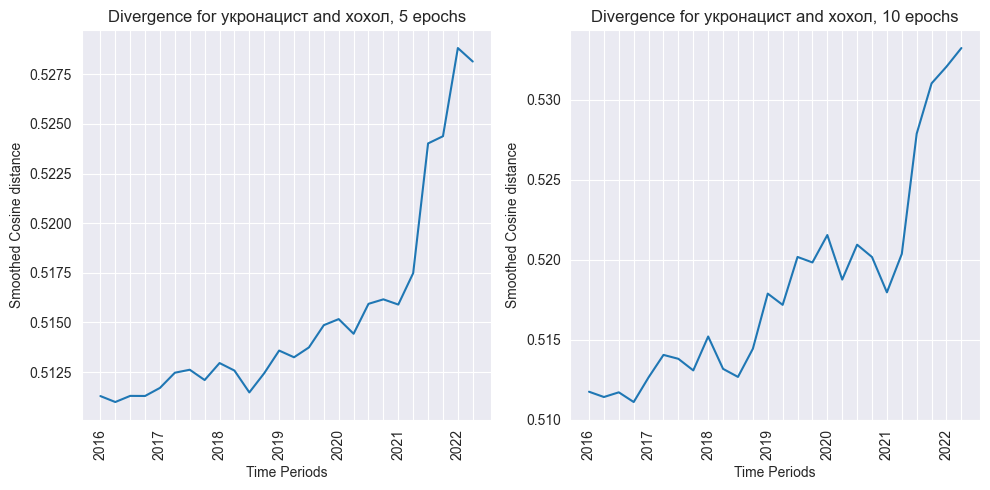

CPU times: user 2min 50s, sys: 29 s, total: 3min 19s
Wall time: 3min 33s


In [664]:
%%time
plot_all('—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç', '—Ö–æ—Ö–æ–ª')

['—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–æ–º', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç—É', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–æ–≤', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–∞', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç—ã', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–µ', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–∞–º–∏', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–∞–º', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–∞—Ö']
********************************************************************************
['—É–∫—Ä–∞–∏–Ω—Ü–∞', '—É–∫—Ä–∞–∏–Ω—Ü–µ', '—É–∫—Ä–∞–∏–Ω—Ü–µ–≤', '—É–∫—Ä–∞–∏–Ω—Ü–µ–º', '—É–∫—Ä–∞–∏–Ω–µ—Ü', '—É–∫—Ä–∞–∏–Ω—Ü–∞–º–∏', '—É–∫—Ä–∞–∏–Ω—Ü–∞—Ö', '—É–∫—Ä–∞–∏–Ω—Ü—É', '—É–∫—Ä–∞–∏–Ω—Ü–∞–º', '—É–∫—Ä–∞–∏–Ω—Ü—ã']
['—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–æ–º', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç—É', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–æ–≤', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–∞', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç—ã', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–µ', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–∞–º–∏', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–∞–º', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–∞—Ö']
********************************************************************************
['—É–∫—Ä–∞–∏–Ω—Ü–∞', '—É–∫—Ä–∞–∏–Ω—Ü–µ', '—É–∫—Ä–∞–∏–Ω—Ü–µ–≤', '—É–∫—Ä–∞–∏–Ω—Ü–µ–º'

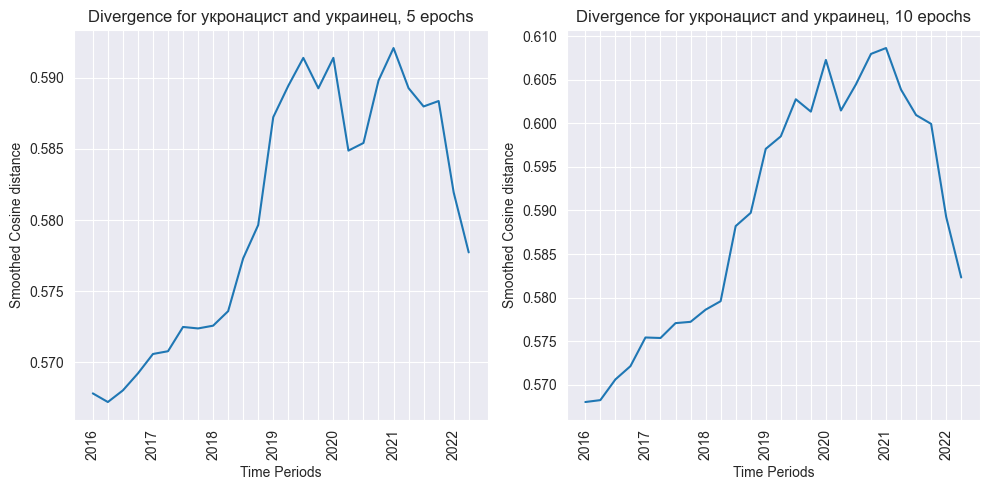

CPU times: user 2min 49s, sys: 27.9 s, total: 3min 17s
Wall time: 3min 31s


In [665]:
%%time
plot_all('—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç', '—É–∫—Ä–∞–∏–Ω–µ—Ü')

['—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–æ–º', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç—É', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–æ–≤', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–∞', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç—ã', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–µ', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–∞–º–∏', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–∞–º', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–∞—Ö']
********************************************************************************
['—É–∫—Ä–∞–º', '—É–∫—Ä–µ', '—É–∫—Ä–∞', '—É–∫—Ä–∞—Ö', '—É–∫—Ä–æ–º', '—É–∫—Ä–∞–º–∏', '—É–∫—Ä–æ–≤', '—É–∫—Ä', '—É–∫—Ä—É', '—É–∫—Ä—ã']
['—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–æ–º', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç—É', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–æ–≤', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–∞', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç—ã', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–µ', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–∞–º–∏', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–∞–º', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–∞—Ö']
********************************************************************************
['—É–∫—Ä–∞–º', '—É–∫—Ä–µ', '—É–∫—Ä–∞', '—É–∫—Ä–∞—Ö', '—É–∫—Ä–æ–º', '—É–∫—Ä–∞–º–∏', '—É–∫—Ä–æ–≤', '—É–∫—Ä', '—É–∫—Ä—É', '—É–∫—Ä—ã']


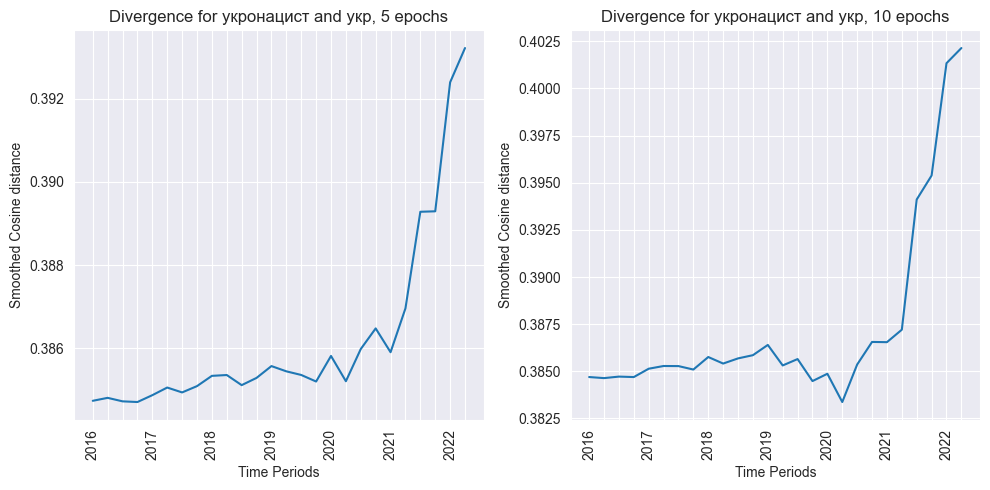

CPU times: user 2min 48s, sys: 27 s, total: 3min 15s
Wall time: 3min 27s


In [666]:
%%time
plot_all('—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç', '—É–∫—Ä')

['—É–∫—Ä–∞–º', '—É–∫—Ä–µ', '—É–∫—Ä–∞', '—É–∫—Ä–∞—Ö', '—É–∫—Ä–æ–º', '—É–∫—Ä–∞–º–∏', '—É–∫—Ä–æ–≤', '—É–∫—Ä', '—É–∫—Ä—É', '—É–∫—Ä—ã']
********************************************************************************
['—É–∫—Ä–∞–∏–Ω—Ü–∞', '—É–∫—Ä–∞–∏–Ω—Ü–µ', '—É–∫—Ä–∞–∏–Ω—Ü–µ–≤', '—É–∫—Ä–∞–∏–Ω—Ü–µ–º', '—É–∫—Ä–∞–∏–Ω–µ—Ü', '—É–∫—Ä–∞–∏–Ω—Ü–∞–º–∏', '—É–∫—Ä–∞–∏–Ω—Ü–∞—Ö', '—É–∫—Ä–∞–∏–Ω—Ü—É', '—É–∫—Ä–∞–∏–Ω—Ü–∞–º', '—É–∫—Ä–∞–∏–Ω—Ü—ã']
['—É–∫—Ä–∞–º', '—É–∫—Ä–µ', '—É–∫—Ä–∞', '—É–∫—Ä–∞—Ö', '—É–∫—Ä–æ–º', '—É–∫—Ä–∞–º–∏', '—É–∫—Ä–æ–≤', '—É–∫—Ä', '—É–∫—Ä—É', '—É–∫—Ä—ã']
********************************************************************************
['—É–∫—Ä–∞–∏–Ω—Ü–∞', '—É–∫—Ä–∞–∏–Ω—Ü–µ', '—É–∫—Ä–∞–∏–Ω—Ü–µ–≤', '—É–∫—Ä–∞–∏–Ω—Ü–µ–º', '—É–∫—Ä–∞–∏–Ω–µ—Ü', '—É–∫—Ä–∞–∏–Ω—Ü–∞–º–∏', '—É–∫—Ä–∞–∏–Ω—Ü–∞—Ö', '—É–∫—Ä–∞–∏–Ω—Ü—É', '—É–∫—Ä–∞–∏–Ω—Ü–∞–º', '—É–∫—Ä–∞–∏–Ω—Ü—ã']


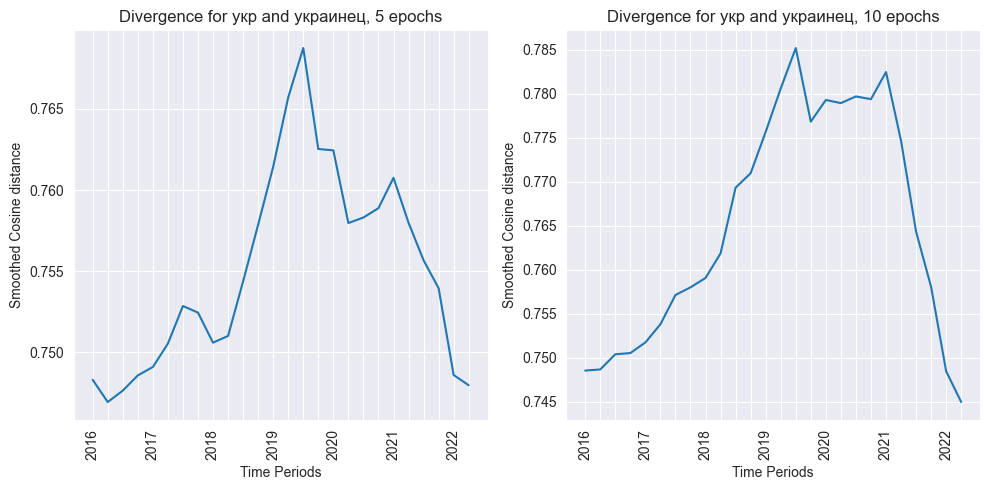

CPU times: user 2min 48s, sys: 28.7 s, total: 3min 17s
Wall time: 3min 32s


In [652]:
%%time
plot_all('—É–∫—Ä', '—É–∫—Ä–∞–∏–Ω–µ—Ü')

['—É–∫—Ä–∞–º', '—É–∫—Ä–µ', '—É–∫—Ä–∞', '—É–∫—Ä–∞—Ö', '—É–∫—Ä–æ–º', '—É–∫—Ä–∞–º–∏', '—É–∫—Ä–æ–≤', '—É–∫—Ä', '—É–∫—Ä—É', '—É–∫—Ä—ã']
********************************************************************************
['—Ö–æ—Ö–ª–æ–º', '—Ö–æ—Ö–ª–æ–≤', '—Ö–æ—Ö–ª–∞', '—Ö–æ—Ö–ª—É', '—Ö–æ—Ö–ª–∞–º', '—Ö–æ—Ö–ª—ã', '—Ö–æ—Ö–ª–∞—Ö', '—Ö–æ—Ö–æ–ª', '—Ö–æ—Ö–ª–µ', '—Ö–æ—Ö–ª–∞–º–∏']
['—É–∫—Ä–∞–º', '—É–∫—Ä–µ', '—É–∫—Ä–∞', '—É–∫—Ä–∞—Ö', '—É–∫—Ä–æ–º', '—É–∫—Ä–∞–º–∏', '—É–∫—Ä–æ–≤', '—É–∫—Ä', '—É–∫—Ä—É', '—É–∫—Ä—ã']
********************************************************************************
['—Ö–æ—Ö–ª–æ–º', '—Ö–æ—Ö–ª–æ–≤', '—Ö–æ—Ö–ª–∞', '—Ö–æ—Ö–ª—É', '—Ö–æ—Ö–ª–∞–º', '—Ö–æ—Ö–ª—ã', '—Ö–æ—Ö–ª–∞—Ö', '—Ö–æ—Ö–æ–ª', '—Ö–æ—Ö–ª–µ', '—Ö–æ—Ö–ª–∞–º–∏']


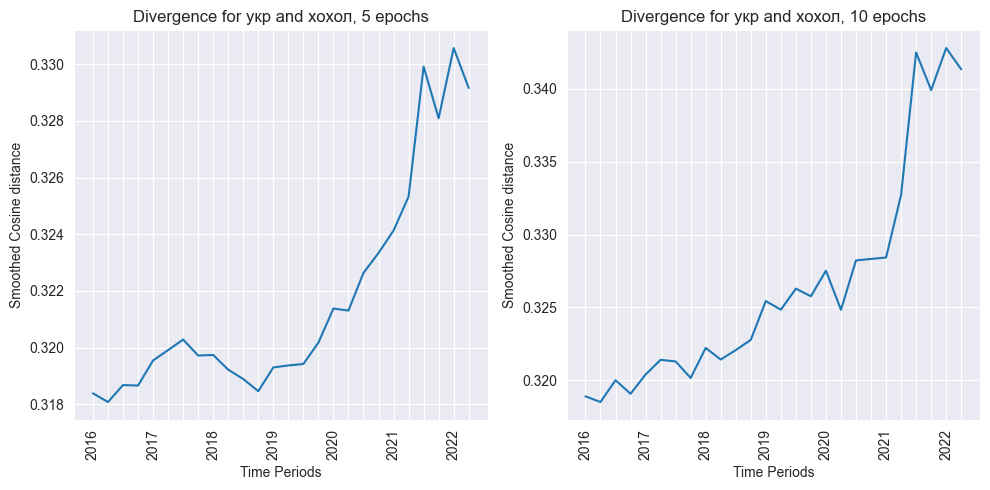

CPU times: user 2min 48s, sys: 28.8 s, total: 3min 17s
Wall time: 3min 31s


In [653]:
%%time
plot_all('—É–∫—Ä', '—Ö–æ—Ö–æ–ª')

['—É–∫—Ä–∞–∏–Ω–∫–æ—é', '—É–∫—Ä–∞–∏–Ω–∫–∏', '—É–∫—Ä–∞–∏–Ω–∫—É', '—É–∫—Ä–∞–∏–Ω–∫–∞–º', '—É–∫—Ä–∞–∏–Ω–æ–∫', '—É–∫—Ä–∞–∏–Ω–∫–∞—Ö', '—É–∫—Ä–∞–∏–Ω–∫–∞', '—É–∫—Ä–∞–∏–Ω–∫–æ–π', '—É–∫—Ä–∞–∏–Ω–∫–∞–º–∏', '—É–∫—Ä–∞–∏–Ω–∫–µ']
********************************************************************************
['—Ö–æ—Ö–ª—É—à–∫–∞—Ö', '—Ö–æ—Ö–ª—É—à–∫–∏', '—Ö–æ—Ö–ª—É—à–∫–µ', '—Ö–æ—Ö–ª—É—à–∫–∞', '—Ö–æ—Ö–ª—É—à–∫–∞–º', '—Ö–æ—Ö–ª—É—à–µ–∫', '—Ö–æ—Ö–ª—É—à–∫–∞–º–∏', '—Ö–æ—Ö–ª—É—à–∫–æ—é', '—Ö–æ—Ö–ª—É—à–∫—É', '—Ö–æ—Ö–ª—É—à–∫–æ–π']
['—É–∫—Ä–∞–∏–Ω–∫–æ—é', '—É–∫—Ä–∞–∏–Ω–∫–∏', '—É–∫—Ä–∞–∏–Ω–∫—É', '—É–∫—Ä–∞–∏–Ω–∫–∞–º', '—É–∫—Ä–∞–∏–Ω–æ–∫', '—É–∫—Ä–∞–∏–Ω–∫–∞—Ö', '—É–∫—Ä–∞–∏–Ω–∫–∞', '—É–∫—Ä–∞–∏–Ω–∫–æ–π', '—É–∫—Ä–∞–∏–Ω–∫–∞–º–∏', '—É–∫—Ä–∞–∏–Ω–∫–µ']
********************************************************************************
['—Ö–æ—Ö–ª—É—à–∫–∞—Ö', '—Ö–æ—Ö–ª—É—à–∫–∏', '—Ö–æ—Ö–ª—É—à–∫–µ', '—Ö–æ—Ö–ª—É—à–∫–∞', '—Ö–æ—Ö–ª—É—à–∫–∞–º', '—Ö–æ—Ö–ª—É—à–µ–∫', '—Ö–æ—Ö–ª—É—à–∫–∞–º–∏', '—Ö–æ—Ö–ª—É—à–∫–æ—é', '—Ö–æ—Ö–ª—É—à–∫—É', '—Ö–æ—Ö–

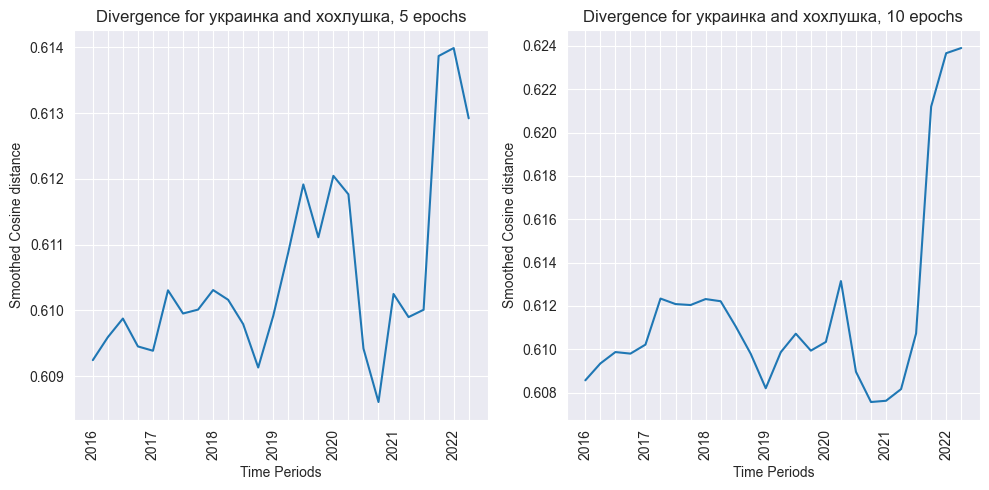

CPU times: user 2min 47s, sys: 28.9 s, total: 3min 16s
Wall time: 3min 30s


In [654]:
%%time
plot_all('—É–∫—Ä–∞–∏–Ω–∫–∞', '—Ö–æ—Ö–ª—É—à–∫–∞')

['—É–∫—Ä–æ–ø–∞–º–∏', '—É–∫—Ä–æ–ø', '—É–∫—Ä–æ–ø—ã', '—É–∫—Ä–æ–ø–∞–º', '—É–∫—Ä–æ–ø–∞—Ö', '—É–∫—Ä–æ–ø–µ', '—É–∫—Ä–æ–ø—É', '—É–∫—Ä–æ–ø–∞', '—É–∫—Ä–æ–ø–æ–º', '—É–∫—Ä–æ–ø–æ–≤']
********************************************************************************
['—Ö–æ—Ö–ª–æ–º', '—Ö–æ—Ö–ª–æ–≤', '—Ö–æ—Ö–ª–∞', '—Ö–æ—Ö–ª—É', '—Ö–æ—Ö–ª–∞–º', '—Ö–æ—Ö–ª—ã', '—Ö–æ—Ö–ª–∞—Ö', '—Ö–æ—Ö–æ–ª', '—Ö–æ—Ö–ª–µ', '—Ö–æ—Ö–ª–∞–º–∏']
['—É–∫—Ä–æ–ø–∞–º–∏', '—É–∫—Ä–æ–ø', '—É–∫—Ä–æ–ø—ã', '—É–∫—Ä–æ–ø–∞–º', '—É–∫—Ä–æ–ø–∞—Ö', '—É–∫—Ä–æ–ø–µ', '—É–∫—Ä–æ–ø—É', '—É–∫—Ä–æ–ø–∞', '—É–∫—Ä–æ–ø–æ–º', '—É–∫—Ä–æ–ø–æ–≤']
********************************************************************************
['—Ö–æ—Ö–ª–æ–º', '—Ö–æ—Ö–ª–æ–≤', '—Ö–æ—Ö–ª–∞', '—Ö–æ—Ö–ª—É', '—Ö–æ—Ö–ª–∞–º', '—Ö–æ—Ö–ª—ã', '—Ö–æ—Ö–ª–∞—Ö', '—Ö–æ—Ö–æ–ª', '—Ö–æ—Ö–ª–µ', '—Ö–æ—Ö–ª–∞–º–∏']


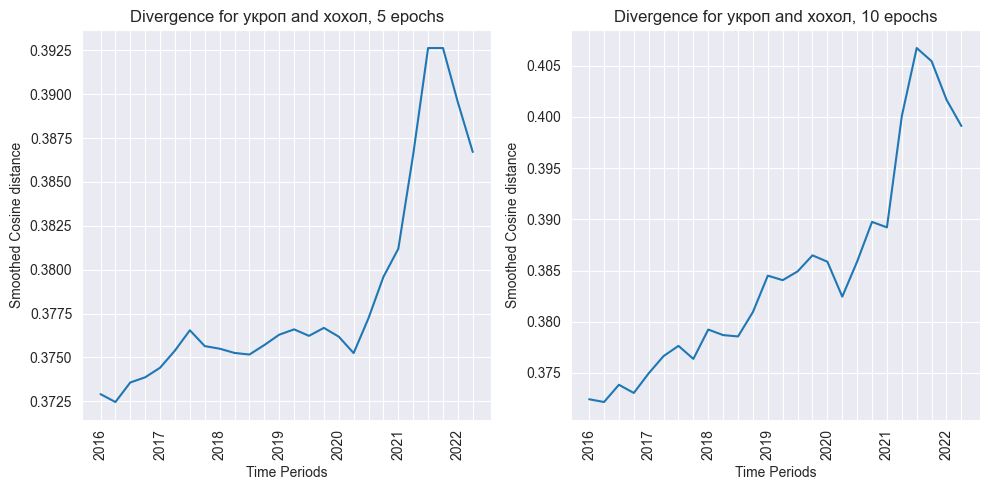

CPU times: user 2min 46s, sys: 28.4 s, total: 3min 15s
Wall time: 3min 29s


In [655]:
%%time
plot_all('—É–∫—Ä–æ–ø', '—Ö–æ—Ö–æ–ª')

['—É–∫—Ä–æ–ø–∞–º–∏', '—É–∫—Ä–æ–ø', '—É–∫—Ä–æ–ø—ã', '—É–∫—Ä–æ–ø–∞–º', '—É–∫—Ä–æ–ø–∞—Ö', '—É–∫—Ä–æ–ø–µ', '—É–∫—Ä–æ–ø—É', '—É–∫—Ä–æ–ø–∞', '—É–∫—Ä–æ–ø–æ–º', '—É–∫—Ä–æ–ø–æ–≤']
********************************************************************************
['—É–∫—Ä–∞–∏–Ω—Ü–∞', '—É–∫—Ä–∞–∏–Ω—Ü–µ', '—É–∫—Ä–∞–∏–Ω—Ü–µ–≤', '—É–∫—Ä–∞–∏–Ω—Ü–µ–º', '—É–∫—Ä–∞–∏–Ω–µ—Ü', '—É–∫—Ä–∞–∏–Ω—Ü–∞–º–∏', '—É–∫—Ä–∞–∏–Ω—Ü–∞—Ö', '—É–∫—Ä–∞–∏–Ω—Ü—É', '—É–∫—Ä–∞–∏–Ω—Ü–∞–º', '—É–∫—Ä–∞–∏–Ω—Ü—ã']
['—É–∫—Ä–æ–ø–∞–º–∏', '—É–∫—Ä–æ–ø', '—É–∫—Ä–æ–ø—ã', '—É–∫—Ä–æ–ø–∞–º', '—É–∫—Ä–æ–ø–∞—Ö', '—É–∫—Ä–æ–ø–µ', '—É–∫—Ä–æ–ø—É', '—É–∫—Ä–æ–ø–∞', '—É–∫—Ä–æ–ø–æ–º', '—É–∫—Ä–æ–ø–æ–≤']
********************************************************************************
['—É–∫—Ä–∞–∏–Ω—Ü–∞', '—É–∫—Ä–∞–∏–Ω—Ü–µ', '—É–∫—Ä–∞–∏–Ω—Ü–µ–≤', '—É–∫—Ä–∞–∏–Ω—Ü–µ–º', '—É–∫—Ä–∞–∏–Ω–µ—Ü', '—É–∫—Ä–∞–∏–Ω—Ü–∞–º–∏', '—É–∫—Ä–∞–∏–Ω—Ü–∞—Ö', '—É–∫—Ä–∞–∏–Ω—Ü—É', '—É–∫—Ä–∞–∏–Ω—Ü–∞–º', '—É–∫—Ä–∞–∏–Ω—Ü—ã']


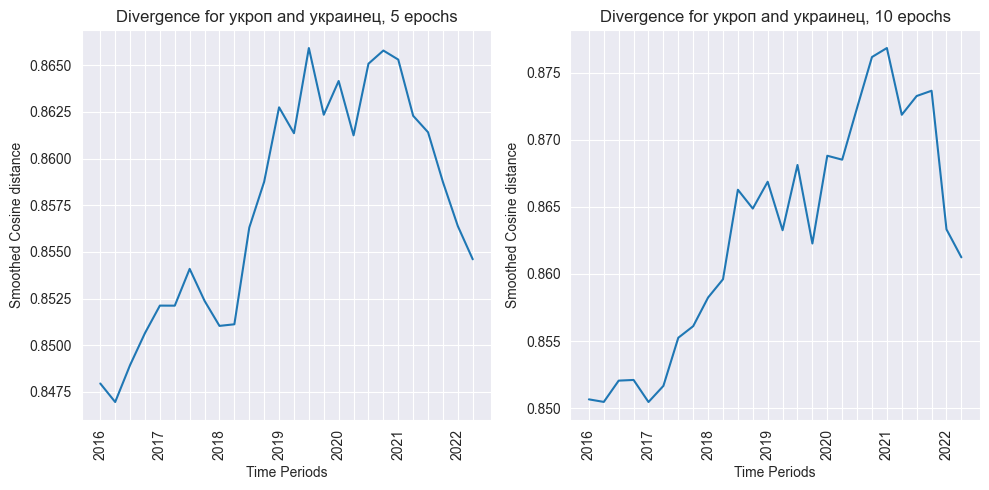

CPU times: user 2min 46s, sys: 28.8 s, total: 3min 15s
Wall time: 3min 29s


In [656]:
%%time
plot_all('—É–∫—Ä–æ–ø', '—É–∫—Ä–∞–∏–Ω–µ—Ü')

['—É–∫—Ä–æ–ø–∞–º–∏', '—É–∫—Ä–æ–ø', '—É–∫—Ä–æ–ø—ã', '—É–∫—Ä–æ–ø–∞–º', '—É–∫—Ä–æ–ø–∞—Ö', '—É–∫—Ä–æ–ø–µ', '—É–∫—Ä–æ–ø—É', '—É–∫—Ä–æ–ø–∞', '—É–∫—Ä–æ–ø–æ–º', '—É–∫—Ä–æ–ø–æ–≤']
********************************************************************************
['—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–æ–º', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç—É', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–æ–≤', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–∞', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç—ã', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–µ', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–∞–º–∏', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–∞–º', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–∞—Ö']
['—É–∫—Ä–æ–ø–∞–º–∏', '—É–∫—Ä–æ–ø', '—É–∫—Ä–æ–ø—ã', '—É–∫—Ä–æ–ø–∞–º', '—É–∫—Ä–æ–ø–∞—Ö', '—É–∫—Ä–æ–ø–µ', '—É–∫—Ä–æ–ø—É', '—É–∫—Ä–æ–ø–∞', '—É–∫—Ä–æ–ø–æ–º', '—É–∫—Ä–æ–ø–æ–≤']
********************************************************************************
['—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–æ–º', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç—É', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–æ–≤', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–∞', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç—ã', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–µ', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–∞–º–∏', '—É–∫—Ä–æ–

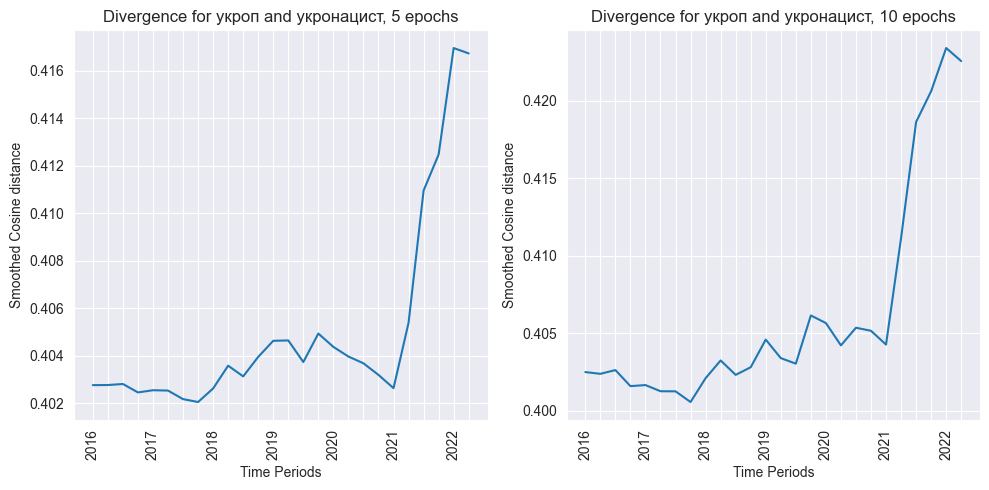

CPU times: user 2min 50s, sys: 28.9 s, total: 3min 19s
Wall time: 3min 33s


In [667]:
%%time
plot_all('—É–∫—Ä–æ–ø', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç')

# Pilot Study

In [132]:
import pandas as pd

In [134]:
%%time
df_full = pd.read_csv('/Users/katerynaburovova/PycharmProjects/dehumanization/data/merged_dataset/df_channels.csv')

<timed exec>:1: DtypeWarning: Columns (4,6,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 1min 15s, sys: 57.6 s, total: 2min 13s
Wall time: 4min 55s


In [187]:
#sample 0.01% of posts
df_sample_01_percent = df_full.sample(frac=0.0001, random_state=42)

In [188]:
len(df_sample_01_percent)

811

In [189]:
df_sample_01_percent_clean = df_sample_01_percent[['date', 'message']].copy()

In [190]:
df_sample_01_percent_clean.reset_index(inplace=True, drop=True)

In [191]:
df_sample_01_percent_clean

date  \
0    2021-05-27 11:03:01+00:00   
1    2020-06-29 11:35:01+00:00   
2    2022-11-16 15:35:00+00:00   
3    2018-12-28 20:39:23+00:00   
4    2021-01-29 09:33:31+00:00   
..                         ...   
806  2021-06-16 17:08:38+00:00   
807  2022-03-27 18:14:20+00:00   
808  2022-03-04 17:42:39+00:00   
809  2022-02-21 12:15:17+00:00   
810  2022-01-20 09:55:38+00:00   

                                               message  
0    –ö–∞—Ç—è ¬´–¢–≤–∞—Ä–∏ –ø–æ –ø–∞—Ä–µ¬ª —Ç–∞–ª–∞–Ω—Ç–ª–∏–≤–æ –∏–∑–æ–±—Ä–∞–∑–∏–ª–∞ –ê–Ω–∞...  
1    –ë–æ–ª–µ–µ 1 –º–ª–Ω —á–µ–ª–æ–≤–µ–∫ –ø—Ä–∏–Ω—è–ª–∏ —É—á–∞—Å—Ç–∏–µ –≤ –æ–Ω–ª–∞–π–Ω-–≥...  
2    –ü–æ–ª—å—Å–∫–∏–π –≥–µ–Ω–µ—Ä–∞–ª –†–æ–º–∞–Ω –ü–æ–ª—å–∫–æ –ø—Ä–µ–¥–ª–æ–∂–∏–ª —Ä–∞—Å—à–∏—Ä...  
3    –ü–æ–≥—Ä–∞–Ω—Å–ª—É–∂–±–∞ –£–∫—Ä–∞–∏–Ω—ã –æ–ø—Ä–æ–≤–µ—Ä–≥–ª–∞ –∑–∞—è–≤–ª–µ–Ω–∏–µ –æ–± –æ...  
4    –ú–∏–Ω—Ç—Ä—É–¥ –ø—Ä–µ–¥–ª–æ–∂–∏–ª 125 –≤–∏–¥–æ–≤ —Ä–∞–±–æ—Ç –¥–ª—è –ø—Ä–æ—Ö–æ–∂–¥–µ...  
..                                                 ...  
806  –ü—É—Ç–∏–Ω —É–≤–∞–∂–∞–µ—Ç –ë–∞–π–¥–µ–Ω–∞. –ö —Ç–æ–º—É –≤—ã–≤–æ–¥—É –ø—Ä–∏—à–ª–∏ —Å–µ...  
807  –ú–æ—Å–∫–æ–≤—Å–∫–∞—è –†–æ—Å–≥–≤–∞—Ä–¥–∏—è –∫ —á–µ–º—É-—Ç–æ –≥–æ—Ç–æ–≤–∏—Ç—Å—è. \n–í...  
808                                                NaN  
809  üòï –ö—É—Ä—Å –µ–≤—Ä–æ —Ç–æ–∂–µ –ø–æ–ª–µ—Ç–µ–ª –∏ –¥–æ—Å—Ç–∏–≥ 89 —Ä—É–±–ª–µ–π –≤–ø...  
810  –õ—É–∫–∞—à–µ–Ω–∫–æ ‚Äì –æ —Ç–æ–º, –∫–∞–∫ –æ–Ω –ø–µ—Ä–µ–±–æ–ª–µ–ª –æ–º–∏–∫—Ä–æ–Ω–æ–º:...  

[811 rows x 2 columns]

In [192]:
import pandas as pd
import numpy as np

df_sample_01_percent_clean['date'] = pd.to_datetime(df_sample_01_percent_clean['date'])

In [193]:
df_sample_01_percent_clean['post_id'] = np.arange(len(df_sample_01_percent_clean))

In [194]:
#predict the dehumanization

In [195]:
#calculate the standard deviation

In [196]:
df_sample_01_percent_clean

date  \
0   2021-05-27 11:03:01+00:00   
1   2020-06-29 11:35:01+00:00   
2   2022-11-16 15:35:00+00:00   
3   2018-12-28 20:39:23+00:00   
4   2021-01-29 09:33:31+00:00   
..                        ...   
806 2021-06-16 17:08:38+00:00   
807 2022-03-27 18:14:20+00:00   
808 2022-03-04 17:42:39+00:00   
809 2022-02-21 12:15:17+00:00   
810 2022-01-20 09:55:38+00:00   

                                               message  post_id  
0    –ö–∞—Ç—è ¬´–¢–≤–∞—Ä–∏ –ø–æ –ø–∞—Ä–µ¬ª —Ç–∞–ª–∞–Ω—Ç–ª–∏–≤–æ –∏–∑–æ–±—Ä–∞–∑–∏–ª–∞ –ê–Ω–∞...        0  
1    –ë–æ–ª–µ–µ 1 –º–ª–Ω —á–µ–ª–æ–≤–µ–∫ –ø—Ä–∏–Ω—è–ª–∏ —É—á–∞—Å—Ç–∏–µ –≤ –æ–Ω–ª–∞–π–Ω-–≥...        1  
2    –ü–æ–ª—å—Å–∫–∏–π –≥–µ–Ω–µ—Ä–∞–ª –†–æ–º–∞–Ω –ü–æ–ª—å–∫–æ –ø—Ä–µ–¥–ª–æ–∂–∏–ª —Ä–∞—Å—à–∏—Ä...        2  
3    –ü–æ–≥—Ä–∞–Ω—Å–ª—É–∂–±–∞ –£–∫—Ä–∞–∏–Ω—ã –æ–ø—Ä–æ–≤–µ—Ä–≥–ª–∞ –∑–∞—è–≤–ª–µ–Ω–∏–µ –æ–± –æ...        3  
4    –ú–∏–Ω—Ç—Ä—É–¥ –ø—Ä–µ–¥–ª–æ–∂–∏–ª 125 –≤–∏–¥–æ–≤ —Ä–∞–±–æ—Ç –¥–ª—è –ø—Ä–æ—Ö–æ–∂–¥–µ...        4  
..                                                 ...      ...  
806  –ü—É—Ç–∏–Ω —É–≤–∞–∂–∞–µ—Ç –ë–∞–π–¥–µ–Ω–∞. –ö —Ç–æ–º—É –≤—ã–≤–æ–¥—É –ø—Ä–∏—à–ª–∏ —Å–µ...      806  
807  –ú–æ—Å–∫–æ–≤—Å–∫–∞—è –†–æ—Å–≥–≤–∞—Ä–¥–∏—è –∫ —á–µ–º—É-—Ç–æ –≥–æ—Ç–æ–≤–∏—Ç—Å—è. \n–í...      807  
808                                                NaN      808  
809  üòï –ö—É—Ä—Å –µ–≤—Ä–æ —Ç–æ–∂–µ –ø–æ–ª–µ—Ç–µ–ª –∏ –¥–æ—Å—Ç–∏–≥ 89 —Ä—É–±–ª–µ–π –≤–ø...      809  
810  –õ—É–∫–∞—à–µ–Ω–∫–æ ‚Äì –æ —Ç–æ–º, –∫–∞–∫ –æ–Ω –ø–µ—Ä–µ–±–æ–ª–µ–ª –æ–º–∏–∫—Ä–æ–Ω–æ–º:...      810  

[811 rows x 3 columns]

In [197]:
import tokenize_uk

df_sample_01_percent_clean['sentences'] = df_sample_01_percent_clean['message'].apply(tokenize_uk.tokenize_sents)

In [198]:
df_sample_01_percent_clean = df_sample_01_percent_clean.explode('sentences')

In [199]:
df_sample_01_percent_clean

date  \
0   2021-05-27 11:03:01+00:00   
0   2021-05-27 11:03:01+00:00   
0   2021-05-27 11:03:01+00:00   
1   2020-06-29 11:35:01+00:00   
2   2022-11-16 15:35:00+00:00   
..                        ...   
810 2022-01-20 09:55:38+00:00   
810 2022-01-20 09:55:38+00:00   
810 2022-01-20 09:55:38+00:00   
810 2022-01-20 09:55:38+00:00   
810 2022-01-20 09:55:38+00:00   

                                               message  post_id  \
0    –ö–∞—Ç—è ¬´–¢–≤–∞—Ä–∏ –ø–æ –ø–∞—Ä–µ¬ª —Ç–∞–ª–∞–Ω—Ç–ª–∏–≤–æ –∏–∑–æ–±—Ä–∞–∑–∏–ª–∞ –ê–Ω–∞...        0   
0    –ö–∞—Ç—è ¬´–¢–≤–∞—Ä–∏ –ø–æ –ø–∞—Ä–µ¬ª —Ç–∞–ª–∞–Ω—Ç–ª–∏–≤–æ –∏–∑–æ–±—Ä–∞–∑–∏–ª–∞ –ê–Ω–∞...        0   
0    –ö–∞—Ç—è ¬´–¢–≤–∞—Ä–∏ –ø–æ –ø–∞—Ä–µ¬ª —Ç–∞–ª–∞–Ω—Ç–ª–∏–≤–æ –∏–∑–æ–±—Ä–∞–∑–∏–ª–∞ –ê–Ω–∞...        0   
1    –ë–æ–ª–µ–µ 1 –º–ª–Ω —á–µ–ª–æ–≤–µ–∫ –ø—Ä–∏–Ω—è–ª–∏ —É—á–∞—Å—Ç–∏–µ –≤ –æ–Ω–ª–∞–π–Ω-–≥...        1   
2    –ü–æ–ª—å—Å–∫–∏–π –≥–µ–Ω–µ—Ä–∞–ª –†–æ–º–∞–Ω –ü–æ–ª—å–∫–æ –ø—Ä–µ–¥–ª–æ–∂–∏–ª —Ä–∞—Å—à–∏—Ä...        2   
..                                                 ...      ...   
810  –õ—É–∫–∞—à–µ–Ω–∫–æ ‚Äì –æ —Ç–æ–º, –∫–∞–∫ –æ–Ω –ø–µ—Ä–µ–±–æ–ª–µ–ª –æ–º–∏–∫—Ä–æ–Ω–æ–º:...      810   
810  –õ—É–∫–∞—à–µ–Ω–∫–æ ‚Äì –æ —Ç–æ–º, –∫–∞–∫ –æ–Ω –ø–µ—Ä–µ–±–æ–ª–µ–ª –æ–º–∏–∫—Ä–æ–Ω–æ–º:...      810   
810  –õ—É–∫–∞—à–µ–Ω–∫–æ ‚Äì –æ —Ç–æ–º, –∫–∞–∫ –æ–Ω –ø–µ—Ä–µ–±–æ–ª–µ–ª –æ–º–∏–∫—Ä–æ–Ω–æ–º:...      810   
810  –õ—É–∫–∞—à–µ–Ω–∫–æ ‚Äì –æ —Ç–æ–º, –∫–∞–∫ –æ–Ω –ø–µ—Ä–µ–±–æ–ª–µ–ª –æ–º–∏–∫—Ä–æ–Ω–æ–º:...      810   
810  –õ—É–∫–∞—à–µ–Ω–∫–æ ‚Äì –æ —Ç–æ–º, –∫–∞–∫ –æ–Ω –ø–µ—Ä–µ–±–æ–ª–µ–ª –æ–º–∏–∫—Ä–æ–Ω–æ–º:...      810   

                                             sentences  
0    –ö–∞—Ç—è ¬´–¢–≤–∞—Ä–∏ –ø–æ –ø–∞—Ä–µ¬ª —Ç–∞–ª–∞–Ω—Ç–ª–∏–≤–æ –∏–∑–æ–±—Ä–∞–∑–∏–ª–∞ –ê–Ω–∞...  
0    –ü–æ–ª—É—á–∏–ª–æ—Å—å –≥–æ—Ä–∞–∑–¥–æ –±–æ–¥—Ä–µ–µ –∏ –∏–Ω—Ç–µ—Ä–µ—Å–Ω–µ–µ –æ—Ä–∏–≥–∏–Ω–∞...  
0    –í –∫–æ–Ω—Ü–µ –µ—â—ë –≥–µ–Ω–∏–∞–ª—å–Ω–∞—è –ø–∞—Ä–æ–¥–∏—é –Ω–∞ ¬´—Ö–∏—Ç¬ª –†–µ—à–µ—Ç–æ...  
1    –ë–æ–ª–µ–µ 1 –º–ª–Ω —á–µ–ª–æ–≤–µ–∫ –ø—Ä–∏–Ω—è–ª–∏ —É—á–∞—Å—Ç–∏–µ –≤ –æ–Ω–ª–∞–π–Ω-–≥...  
2    –ü–æ–ª—å—Å–∫–∏–π –≥–µ–Ω–µ—Ä–∞–ª –†–æ–º–∞–Ω –ü–æ–ª—å–∫–æ –ø—Ä–µ–¥–ª–æ–∂–∏–ª —Ä–∞—Å—à–∏—Ä...  
..                                                 ...  
810                                     –ï—Å–ª–∏ –æ–Ω –≤–∏—Ä—É—Å.  
810  –Ø –ø–æ–¥–æ–∑—Ä–µ–≤–∞—é, —á—Ç–æ –º—ã —Å–∫–∞—Ç–∏–ª–∏—Å—å —É–∂–µ –∫ –æ–±—ã—á–Ω–æ–º—É ...  
810                              –û–Ω –Ω–µ –¥–∞–µ—Ç –ø–Ω–µ–≤–º–æ–Ω–∏–π.  
810  –Ø –≥–æ–≤–æ—Ä—é —ç—Ç–æ –∫–∞–∫ —á–µ–ª–æ–≤–µ–∫, –∫–æ—Ç–æ—Ä—ã–π —Å–∞–º –≤—Ç–æ—Ä–æ–π —Ä...  
810  –Ø –Ω–∞ –Ω–æ–≥–∞—Ö –µ–≥–æ –ø–µ—Ä–µ–Ω–µ—Å –∏ –∑–∞–º–µ—Ç–∏–ª —Ç–æ–ª—å–∫–æ –≤ –∫–æ–Ω—Ü...  

[2685 rows x 4 columns]

In [200]:
pilot_sent_list = df_sample_01_percent_clean.sentences.to_list()

### pre-processing sentences for SpERT

In [201]:
import spacy

nlp = spacy.load("ru_core_news_md")

In [202]:
def tokenize_text(text):
    return [token.text for token in nlp(text)]

In [203]:
def get_SpERT_formatted_input(X):
    formatted_texts = []

    for text in X.sentences:
        tokens = tokenize_text(text)
        formatted_text = {"tokens": tokens}
        formatted_texts.append([formatted_text, tokens, text])

    return formatted_texts

In [204]:
%%time
Pilot_texts_formatted = get_SpERT_formatted_input(df_sample_01_percent_clean)

CPU times: user 19.5 s, sys: 283 ms, total: 19.8 s
Wall time: 20 s


In [205]:
pilot_list_of_dicts = []
for doc in Pilot_texts_formatted:
    pilot_list_of_dicts.append(doc[0])

In [207]:
import json

pilot_sample = '/Users/katerynaburovova/PycharmProjects/dehumanization/spert/data/datasets/test_datasets/pilot_sample.json'

with open(pilot_sample, 'w', encoding='utf-8') as f:
    json.dump(pilot_list_of_dicts, f, ensure_ascii=False, indent=4)

In [208]:
path_to_pilot_predictions = '/Users/katerynaburovova/PycharmProjects/dehumanization/spert/data/predictions_pilot.json'

In [209]:
with open(path_to_pilot_predictions, 'r') as file:
    data_pilot = json.load(file)

In [210]:
data_pilot

[{'tokens': ['–ö–∞—Ç—è',
   '¬´',
   '–¢–≤–∞—Ä–∏',
   '–ø–æ',
   '–ø–∞—Ä–µ',
   '¬ª',
   '—Ç–∞–ª–∞–Ω—Ç–ª–∏–≤–æ',
   '–∏–∑–æ–±—Ä–∞–∑–∏–ª–∞',
   '–ê–Ω–∞—Å—Ç–∞—Å–∏—é',
   '(',
   '–æ–Ω–∞',
   '–∂–µ',
   '–ê–º–∏–Ω–∞',
   ',',
   '–∞–≤—Ç–æ—Ä',
   '–∫–Ω–∏–≥–∏',
   '¬´',
   '–°–µ–≥–æ–¥–Ω—è',
   '—è',
   '—Ö—Ä–∏—Å—Ç–∏–∞–Ω–∫–∞',
   ',',
   '–∞',
   '–∑–∞–≤—Ç—Ä–∞',
   '–º—É—Å—É–ª—å–º–∞–Ω–∫–∞',
   '¬ª',
   ')',
   '–†–µ—à–µ—Ç–æ–≤—É',
   '.'],
  'entities': [],
  'relations': []},
 {'tokens': ['–ü–æ–ª—É—á–∏–ª–æ—Å—å',
   '–≥–æ—Ä–∞–∑–¥–æ',
   '–±–æ–¥—Ä–µ–µ',
   '–∏',
   '–∏–Ω—Ç–µ—Ä–µ—Å–Ω–µ–µ',
   '–æ—Ä–∏–≥–∏–Ω–∞–ª—å–Ω–æ–≥–æ',
   '¬´',
   '–ú–æ–Ω–æ–ª–æ–≥–∞',
   '¬ª',
   '.'],
  'entities': [],
  'relations': []},
 {'tokens': ['–í',
   '–∫–æ–Ω—Ü–µ',
   '–µ—â—ë',
   '–≥–µ–Ω–∏–∞–ª—å–Ω–∞—è',
   '–ø–∞—Ä–æ–¥–∏—é',
   '–Ω–∞',
   '¬´',
   '—Ö–∏—Ç',
   '¬ª',
   '–†–µ—à–µ—Ç–æ–≤–æ–π',
   '¬´',
   '–ò—Å—á–µ–∑–Ω–∏',
   '¬ª',
   '.'],
  'entities': [],
  'relations': []},
 {'tokens': ['–ë–æ–ª–µ–µ',
   '1',
   '–º–

In [211]:
df_pilot = pd.DataFrame(data_pilot)

In [219]:
df_pilot['post_id'] = np.arange(len(df_pilot))

In [220]:
df_pilot.iloc[522]

tokens       [–ù–µ, —Ç–æ–ª—å–∫–æ, –æ—Å–≤–æ–±–æ–∂–¥–∞—Ç—å, ,, –Ω–æ, –∏, –≤—ã–∂–∏–≥–∞—Ç—å, ...
entities     [{'type': 'LOW_UH_LOW_NH', 'start': 10, 'end':...
relations                                                   []
post_id                                                    522
Name: 522, dtype: object

In [221]:
df_pilot_merged = df_sample_01_percent_clean.merge(df_pilot, on='post_id', how='inner')

In [222]:
len(df_pilot_merged)

2685

In [223]:
df_pilot_merged

date  \
0    2021-05-27 11:03:01+00:00   
1    2021-05-27 11:03:01+00:00   
2    2021-05-27 11:03:01+00:00   
3    2020-06-29 11:35:01+00:00   
4    2022-11-16 15:35:00+00:00   
...                        ...   
2680 2022-01-20 09:55:38+00:00   
2681 2022-01-20 09:55:38+00:00   
2682 2022-01-20 09:55:38+00:00   
2683 2022-01-20 09:55:38+00:00   
2684 2022-01-20 09:55:38+00:00   

                                                message  post_id  \
0     –ö–∞—Ç—è ¬´–¢–≤–∞—Ä–∏ –ø–æ –ø–∞—Ä–µ¬ª —Ç–∞–ª–∞–Ω—Ç–ª–∏–≤–æ –∏–∑–æ–±—Ä–∞–∑–∏–ª–∞ –ê–Ω–∞...        0   
1     –ö–∞—Ç—è ¬´–¢–≤–∞—Ä–∏ –ø–æ –ø–∞—Ä–µ¬ª —Ç–∞–ª–∞–Ω—Ç–ª–∏–≤–æ –∏–∑–æ–±—Ä–∞–∑–∏–ª–∞ –ê–Ω–∞...        0   
2     –ö–∞—Ç—è ¬´–¢–≤–∞—Ä–∏ –ø–æ –ø–∞—Ä–µ¬ª —Ç–∞–ª–∞–Ω—Ç–ª–∏–≤–æ –∏–∑–æ–±—Ä–∞–∑–∏–ª–∞ –ê–Ω–∞...        0   
3     –ë–æ–ª–µ–µ 1 –º–ª–Ω —á–µ–ª–æ–≤–µ–∫ –ø—Ä–∏–Ω—è–ª–∏ —É—á–∞—Å—Ç–∏–µ –≤ –æ–Ω–ª–∞–π–Ω-–≥...        1   
4     –ü–æ–ª—å—Å–∫–∏–π –≥–µ–Ω–µ—Ä–∞–ª –†–æ–º–∞–Ω –ü–æ–ª—å–∫–æ –ø—Ä–µ–¥–ª–æ–∂–∏–ª —Ä–∞—Å—à–∏—Ä...        2   
...                                                 ...      ...   
2680  –õ—É–∫–∞—à–µ–Ω–∫–æ ‚Äì –æ —Ç–æ–º, –∫–∞–∫ –æ–Ω –ø–µ—Ä–µ–±–æ–ª–µ–ª –æ–º–∏–∫—Ä–æ–Ω–æ–º:...      810   
2681  –õ—É–∫–∞—à–µ–Ω–∫–æ ‚Äì –æ —Ç–æ–º, –∫–∞–∫ –æ–Ω –ø–µ—Ä–µ–±–æ–ª–µ–ª –æ–º–∏–∫—Ä–æ–Ω–æ–º:...      810   
2682  –õ—É–∫–∞—à–µ–Ω–∫–æ ‚Äì –æ —Ç–æ–º, –∫–∞–∫ –æ–Ω –ø–µ—Ä–µ–±–æ–ª–µ–ª –æ–º–∏–∫—Ä–æ–Ω–æ–º:...      810   
2683  –õ—É–∫–∞—à–µ–Ω–∫–æ ‚Äì –æ —Ç–æ–º, –∫–∞–∫ –æ–Ω –ø–µ—Ä–µ–±–æ–ª–µ–ª –æ–º–∏–∫—Ä–æ–Ω–æ–º:...      810   
2684  –õ—É–∫–∞—à–µ–Ω–∫–æ ‚Äì –æ —Ç–æ–º, –∫–∞–∫ –æ–Ω –ø–µ—Ä–µ–±–æ–ª–µ–ª –æ–º–∏–∫—Ä–æ–Ω–æ–º:...      810   

                                              sentences  \
0     –ö–∞—Ç—è ¬´–¢–≤–∞—Ä–∏ –ø–æ –ø–∞—Ä–µ¬ª —Ç–∞–ª–∞–Ω—Ç–ª–∏–≤–æ –∏–∑–æ–±—Ä–∞–∑–∏–ª–∞ –ê–Ω–∞...   
1     –ü–æ–ª—É—á–∏–ª–æ—Å—å –≥–æ—Ä–∞–∑–¥–æ –±–æ–¥—Ä–µ–µ –∏ –∏–Ω—Ç–µ—Ä–µ—Å–Ω–µ–µ –æ—Ä–∏–≥–∏–Ω–∞...   
2     –í –∫–æ–Ω—Ü–µ –µ—â—ë –≥–µ–Ω–∏–∞–ª—å–Ω–∞—è –ø–∞—Ä–æ–¥–∏—é –Ω–∞ ¬´—Ö–∏—Ç¬ª –†–µ—à–µ—Ç–æ...   
3     –ë–æ–ª–µ–µ 1 –º–ª–Ω —á–µ–ª–æ–≤–µ–∫ –ø—Ä–∏–Ω—è–ª–∏ —É—á–∞—Å—Ç–∏–µ –≤ –æ–Ω–ª–∞–π–Ω-–≥...   
4     –ü–æ–ª—å—Å–∫–∏–π –≥–µ–Ω–µ—Ä–∞–ª –†–æ–º–∞–Ω –ü–æ–ª—å–∫–æ –ø—Ä–µ–¥–ª–æ–∂–∏–ª —Ä–∞—Å—à–∏—Ä...   
...                                                 ...   
2680                                     –ï—Å–ª–∏ –æ–Ω –≤–∏—Ä—É—Å.   
2681  –Ø –ø–æ–¥–æ–∑—Ä–µ–≤–∞—é, —á—Ç–æ –º—ã —Å–∫–∞—Ç–∏–ª–∏—Å—å —É–∂–µ –∫ –æ–±—ã—á–Ω–æ–º—É ...   
2682                              –û–Ω –Ω–µ –¥–∞–µ—Ç –ø–Ω–µ–≤–º–æ–Ω–∏–π.   
2683  –Ø –≥–æ–≤–æ—Ä—é —ç—Ç–æ –∫–∞–∫ —á–µ–ª–æ–≤–µ–∫, –∫–æ—Ç–æ—Ä—ã–π —Å–∞–º –≤—Ç–æ—Ä–æ–π —Ä...   
2684  –Ø –Ω–∞ –Ω–æ–≥–∞—Ö –µ–≥–æ –ø–µ—Ä–µ–Ω–µ—Å –∏ –∑–∞–º–µ—Ç–∏–ª —Ç–æ–ª—å–∫–æ –≤ –∫–æ–Ω—Ü...   

                                                 tokens  \
0     [–ö–∞—Ç—è, ¬´, –¢–≤–∞—Ä–∏, –ø–æ, –ø–∞—Ä–µ, ¬ª, —Ç–∞–ª–∞–Ω—Ç–ª–∏–≤–æ, –∏–∑–æ–±...   
1     [–ö–∞—Ç—è, ¬´, –¢–≤–∞—Ä–∏, –ø–æ, –ø–∞—Ä–µ, ¬ª, —Ç–∞–ª–∞–Ω—Ç–ª–∏–≤–æ, –∏–∑–æ–±...   
2     [–ö–∞—Ç—è, ¬´, –¢–≤–∞—Ä–∏, –ø–æ, –ø–∞—Ä–µ, ¬ª, —Ç–∞–ª–∞–Ω—Ç–ª–∏–≤–æ, –∏–∑–æ–±...   
3     [–ü–æ–ª—É—á–∏–ª–æ—Å—å, –≥–æ—Ä–∞–∑–¥–æ, –±–æ–¥—Ä–µ–µ, –∏, –∏–Ω—Ç–µ—Ä–µ—Å–Ω–µ–µ, –æ...   
4     [–í, –∫–æ–Ω—Ü–µ, –µ—â—ë, –≥–µ–Ω–∏–∞–ª—å–Ω–∞—è, –ø–∞—Ä–æ–¥–∏—é, –Ω–∞, ¬´, —Ö–∏...   
...                                                 ...   
2680  [‚ñ™, Ô∏è–ó–µ–ª–µ–Ω—Å–∫–∏–π, –ø–æ—Å–µ—Ç–∏—Ç, –∫–æ–Ω—Ñ–µ—Ä–µ–Ω—Ü–∏—é, –ø–æ, –±–µ–∑–æ...   
2681  [‚ñ™, Ô∏è–ó–µ–ª–µ–Ω—Å–∫–∏–π, –ø–æ—Å–µ—Ç–∏—Ç, –∫–æ–Ω—Ñ–µ—Ä–µ–Ω—Ü–∏—é, –ø–æ, –±–µ–∑–æ...   
2682  [‚ñ™, Ô∏è–ó–µ–ª–µ–Ω—Å–∫–∏–π, –ø–æ—Å–µ—Ç–∏—Ç, –∫–æ–Ω—Ñ–µ—Ä–µ–Ω—Ü–∏—é, –ø–æ, –±–µ–∑–æ...   
2683  [‚ñ™, Ô∏è–ó–µ–ª–µ–Ω—Å–∫–∏–π, –ø–æ—Å–µ—Ç–∏—Ç, –∫–æ–Ω—Ñ–µ—Ä–µ–Ω—Ü–∏—é, –ø–æ, –±–µ–∑–æ...   
2684  [‚ñ™, Ô∏è–ó–µ–ª–µ–Ω—Å–∫–∏–π, –ø–æ—Å–µ—Ç–∏—Ç, –∫–æ–Ω—Ñ–µ—Ä–µ–Ω—Ü–∏—é, –ø–æ, –±–µ–∑–æ...   

                                               entities relations  
0                                                    []        []  
1                                                    []        []  
2                                                    []        []  
3                                        

In [225]:
df_pilot_merged.entities.value_counts()

[]                                                     2643
[{'type': 'LOW_UH_HIGH_NH', 'start': 7, 'end': 8}]       17
[{'type': 'HIGH_UH_LOW_NH', 'start': 0, 'end': 2}]       14
[{'type': 'LOW_UH_LOW_NH', 'start': 10, 'end': 11}]       6
[{'type': 'HIGH_UH_LOW_NH', 'start': 6, 'end': 7}]        2
[{'type': 'LOW_UH_LOW_NH', 'start': 7, 'end': 9}]         1
[{'type': 'HIGH_UH_LOW_NH', 'start': 0, 'end': 1}]        1
[{'type': 'HIGH_UH_LOW_NH', 'start': 1, 'end': 2}]        1
Name: entities, dtype: int64

In [237]:
entities_list = ['LOW_UH_HIGH_NH','LOW_UH_LOW_NH', 'HIGH_UH_LOW_NH', 'HIGH_UH_HIGH_NH']

In [238]:
for entity in entities_list:
    df_pilot_merged[entity] = df_pilot_merged['entities'].apply(lambda x: sum([1 for i in x if i['type'] == entity]))

In [239]:
df_pilot_merged

date  \
0    2021-05-27 11:03:01+00:00   
1    2021-05-27 11:03:01+00:00   
2    2021-05-27 11:03:01+00:00   
3    2020-06-29 11:35:01+00:00   
4    2022-11-16 15:35:00+00:00   
...                        ...   
2680 2022-01-20 09:55:38+00:00   
2681 2022-01-20 09:55:38+00:00   
2682 2022-01-20 09:55:38+00:00   
2683 2022-01-20 09:55:38+00:00   
2684 2022-01-20 09:55:38+00:00   

                                                message  post_id  \
0     –ö–∞—Ç—è ¬´–¢–≤–∞—Ä–∏ –ø–æ –ø–∞—Ä–µ¬ª —Ç–∞–ª–∞–Ω—Ç–ª–∏–≤–æ –∏–∑–æ–±—Ä–∞–∑–∏–ª–∞ –ê–Ω–∞...        0   
1     –ö–∞—Ç—è ¬´–¢–≤–∞—Ä–∏ –ø–æ –ø–∞—Ä–µ¬ª —Ç–∞–ª–∞–Ω—Ç–ª–∏–≤–æ –∏–∑–æ–±—Ä–∞–∑–∏–ª–∞ –ê–Ω–∞...        0   
2     –ö–∞—Ç—è ¬´–¢–≤–∞—Ä–∏ –ø–æ –ø–∞—Ä–µ¬ª —Ç–∞–ª–∞–Ω—Ç–ª–∏–≤–æ –∏–∑–æ–±—Ä–∞–∑–∏–ª–∞ –ê–Ω–∞...        0   
3     –ë–æ–ª–µ–µ 1 –º–ª–Ω —á–µ–ª–æ–≤–µ–∫ –ø—Ä–∏–Ω—è–ª–∏ —É—á–∞—Å—Ç–∏–µ –≤ –æ–Ω–ª–∞–π–Ω-–≥...        1   
4     –ü–æ–ª—å—Å–∫–∏–π –≥–µ–Ω–µ—Ä–∞–ª –†–æ–º–∞–Ω –ü–æ–ª—å–∫–æ –ø—Ä–µ–¥–ª–æ–∂–∏–ª —Ä–∞—Å—à–∏—Ä...        2   
...                                                 ...      ...   
2680  –õ—É–∫–∞—à–µ–Ω–∫–æ ‚Äì –æ —Ç–æ–º, –∫–∞–∫ –æ–Ω –ø–µ—Ä–µ–±–æ–ª–µ–ª –æ–º–∏–∫—Ä–æ–Ω–æ–º:...      810   
2681  –õ—É–∫–∞—à–µ–Ω–∫–æ ‚Äì –æ —Ç–æ–º, –∫–∞–∫ –æ–Ω –ø–µ—Ä–µ–±–æ–ª–µ–ª –æ–º–∏–∫—Ä–æ–Ω–æ–º:...      810   
2682  –õ—É–∫–∞—à–µ–Ω–∫–æ ‚Äì –æ —Ç–æ–º, –∫–∞–∫ –æ–Ω –ø–µ—Ä–µ–±–æ–ª–µ–ª –æ–º–∏–∫—Ä–æ–Ω–æ–º:...      810   
2683  –õ—É–∫–∞—à–µ–Ω–∫–æ ‚Äì –æ —Ç–æ–º, –∫–∞–∫ –æ–Ω –ø–µ—Ä–µ–±–æ–ª–µ–ª –æ–º–∏–∫—Ä–æ–Ω–æ–º:...      810   
2684  –õ—É–∫–∞—à–µ–Ω–∫–æ ‚Äì –æ —Ç–æ–º, –∫–∞–∫ –æ–Ω –ø–µ—Ä–µ–±–æ–ª–µ–ª –æ–º–∏–∫—Ä–æ–Ω–æ–º:...      810   

                                              sentences  \
0     –ö–∞—Ç—è ¬´–¢–≤–∞—Ä–∏ –ø–æ –ø–∞—Ä–µ¬ª —Ç–∞–ª–∞–Ω—Ç–ª–∏–≤–æ –∏–∑–æ–±—Ä–∞–∑–∏–ª–∞ –ê–Ω–∞...   
1     –ü–æ–ª—É—á–∏–ª–æ—Å—å –≥–æ—Ä–∞–∑–¥–æ –±–æ–¥—Ä–µ–µ –∏ –∏–Ω—Ç–µ—Ä–µ—Å–Ω–µ–µ –æ—Ä–∏–≥–∏–Ω–∞...   
2     –í –∫–æ–Ω—Ü–µ –µ—â—ë –≥–µ–Ω–∏–∞–ª—å–Ω–∞—è –ø–∞—Ä–æ–¥–∏—é –Ω–∞ ¬´—Ö–∏—Ç¬ª –†–µ—à–µ—Ç–æ...   
3     –ë–æ–ª–µ–µ 1 –º–ª–Ω —á–µ–ª–æ–≤–µ–∫ –ø—Ä–∏–Ω—è–ª–∏ —É—á–∞—Å—Ç–∏–µ –≤ –æ–Ω–ª–∞–π–Ω-–≥...   
4     –ü–æ–ª—å—Å–∫–∏–π –≥–µ–Ω–µ—Ä–∞–ª –†–æ–º–∞–Ω –ü–æ–ª—å–∫–æ –ø—Ä–µ–¥–ª–æ–∂–∏–ª —Ä–∞—Å—à–∏—Ä...   
...                                                 ...   
2680                                     –ï—Å–ª–∏ –æ–Ω –≤–∏—Ä—É—Å.   
2681  –Ø –ø–æ–¥–æ–∑—Ä–µ–≤–∞—é, —á—Ç–æ –º—ã —Å–∫–∞—Ç–∏–ª–∏—Å—å —É–∂–µ –∫ –æ–±—ã—á–Ω–æ–º—É ...   
2682                              –û–Ω –Ω–µ –¥–∞–µ—Ç –ø–Ω–µ–≤–º–æ–Ω–∏–π.   
2683  –Ø –≥–æ–≤–æ—Ä—é —ç—Ç–æ –∫–∞–∫ —á–µ–ª–æ–≤–µ–∫, –∫–æ—Ç–æ—Ä—ã–π —Å–∞–º –≤—Ç–æ—Ä–æ–π —Ä...   
2684  –Ø –Ω–∞ –Ω–æ–≥–∞—Ö –µ–≥–æ –ø–µ—Ä–µ–Ω–µ—Å –∏ –∑–∞–º–µ—Ç–∏–ª —Ç–æ–ª—å–∫–æ –≤ –∫–æ–Ω—Ü...   

                                                 tokens  \
0     [–ö–∞—Ç—è, ¬´, –¢–≤–∞—Ä–∏, –ø–æ, –ø–∞—Ä–µ, ¬ª, —Ç–∞–ª–∞–Ω—Ç–ª–∏–≤–æ, –∏–∑–æ–±...   
1     [–ö–∞—Ç—è, ¬´, –¢–≤–∞—Ä–∏, –ø–æ, –ø–∞—Ä–µ, ¬ª, —Ç–∞–ª–∞–Ω—Ç–ª–∏–≤–æ, –∏–∑–æ–±...   
2     [–ö–∞—Ç—è, ¬´, –¢–≤–∞—Ä–∏, –ø–æ, –ø–∞—Ä–µ, ¬ª, —Ç–∞–ª–∞–Ω—Ç–ª–∏–≤–æ, –∏–∑–æ–±...   
3     [–ü–æ–ª—É—á–∏–ª–æ—Å—å, –≥–æ—Ä–∞–∑–¥–æ, –±–æ–¥—Ä–µ–µ, –∏, –∏–Ω—Ç–µ—Ä–µ—Å–Ω–µ–µ, –æ...   
4     [–í, –∫–æ–Ω—Ü–µ, –µ—â—ë, –≥–µ–Ω–∏–∞–ª—å–Ω–∞—è, –ø–∞—Ä–æ–¥–∏—é, –Ω–∞, ¬´, —Ö–∏...   
...                                                 ...   
2680  [‚ñ™, Ô∏è–ó–µ–ª–µ–Ω—Å–∫–∏–π, –ø–æ—Å–µ—Ç–∏—Ç, –∫–æ–Ω—Ñ–µ—Ä–µ–Ω—Ü–∏—é, –ø–æ, –±–µ–∑–æ...   
2681  [‚ñ™, Ô∏è–ó–µ–ª–µ–Ω—Å–∫–∏–π, –ø–æ—Å–µ—Ç–∏—Ç, –∫–æ–Ω—Ñ–µ—Ä–µ–Ω—Ü–∏—é, –ø–æ, –±–µ–∑–æ...   
2682  [‚ñ™, Ô∏è–ó–µ–ª–µ–Ω—Å–∫–∏–π, –ø–æ—Å–µ—Ç–∏—Ç, –∫–æ–Ω—Ñ–µ—Ä–µ–Ω—Ü–∏—é, –ø–æ, –±–µ–∑–æ...   
2683  [‚ñ™, Ô∏è–ó–µ–ª–µ–Ω—Å–∫–∏–π, –ø–æ—Å–µ—Ç–∏—Ç, –∫–æ–Ω—Ñ–µ—Ä–µ–Ω—Ü–∏—é, –ø–æ, –±–µ–∑–æ...   
2684  [‚ñ™, Ô∏è–ó–µ–ª–µ–Ω—Å–∫–∏–π, –ø–æ—Å–µ—Ç–∏—Ç, –∫–æ–Ω—Ñ–µ—Ä–µ–Ω—Ü–∏—é, –ø–æ, –±–µ–∑–æ...   

                                               entities relations  \
0                                                    []        []   
1                                                    []        []   
2                                                    []        []   
3                                    

In [240]:
df_pilot_merged.entities.value_counts()

[]                                                     2643
[{'type': 'LOW_UH_HIGH_NH', 'start': 7, 'end': 8}]       17
[{'type': 'HIGH_UH_LOW_NH', 'start': 0, 'end': 2}]       14
[{'type': 'LOW_UH_LOW_NH', 'start': 10, 'end': 11}]       6
[{'type': 'HIGH_UH_LOW_NH', 'start': 6, 'end': 7}]        2
[{'type': 'LOW_UH_LOW_NH', 'start': 7, 'end': 9}]         1
[{'type': 'HIGH_UH_LOW_NH', 'start': 0, 'end': 1}]        1
[{'type': 'HIGH_UH_LOW_NH', 'start': 1, 'end': 2}]        1
Name: entities, dtype: int64

In [241]:
df_pilot_merged.LOW_UH_HIGH_NH.value_counts()

0    2668
1      17
Name: LOW_UH_HIGH_NH, dtype: int64

In [243]:
average_entities_per_post = df_pilot_merged[entities_list].mean()

In [244]:
average_entities_per_post

LOW_UH_HIGH_NH     0.006331
LOW_UH_LOW_NH      0.002607
HIGH_UH_LOW_NH     0.006704
HIGH_UH_HIGH_NH    0.000000
dtype: float64

In [248]:
grouped_df = df_pilot_merged.groupby('post_id')[entities_list].mean().reset_index()

In [251]:
grouped_df.LOW_UH_LOW_NH

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
806    0.0
807    0.0
808    0.0
809    0.0
810    0.0
Name: LOW_UH_LOW_NH, Length: 811, dtype: float64

In [253]:
import numpy as np

sigma_LOW_UH_LOW_NH = np.std(grouped_df.LOW_UH_LOW_NH, ddof=1)
sigma_LOW_UH_LOW_NH

0.04962909114907327

In [254]:
sigma_LOW_UH_HIGH_NH = np.std(grouped_df.LOW_UH_HIGH_NH, ddof=1)
sigma_LOW_UH_HIGH_NH

0.03511474936103117

In [255]:
sigma_HIGH_UH_LOW_NH = np.std(grouped_df.HIGH_UH_LOW_NH, ddof=1)
sigma_HIGH_UH_LOW_NH

0.08574733453427218

In [258]:
import scipy.stats as stats
import math

confidence_level = 0.95  # for a 95% confidence interval
margin_of_error = 0.01  # for a 1% margin of error
z_score = abs(stats.norm.ppf((1 - confidence_level) / 2))
sample_size = ((z_score**2) * (sigma_HIGH_UH_LOW_NH**2)) / (margin_of_error**2)

print(f"The required sample size is {sample_size}")

The required sample size is 282.44730791056054


In [259]:
confidence_level = 0.95  # for a 95% confidence interval
margin_of_error = 0.01  # for a 1% margin of error
z_score = abs(stats.norm.ppf((1 - confidence_level) / 2))
sample_size = ((z_score**2) * (sigma_LOW_UH_HIGH_NH**2)) / (margin_of_error**2)

print(f"The required sample size is {sample_size}")

The required sample size is 47.36693983593248


In [260]:
confidence_level = 0.95  # for a 95% confidence interval
margin_of_error = 0.01  # for a 1% margin of error
z_score = abs(stats.norm.ppf((1 - confidence_level) / 2))
sample_size = ((z_score**2) * (sigma_LOW_UH_LOW_NH**2)) / (margin_of_error**2)

print(f"The required sample size is {sample_size}")

The required sample size is 94.6169242648627


### We will use 1000 posts per timestep to cover that.

1. get the timesteps

In [261]:
import os

slices_directory = '/Users/katerynaburovova/PycharmProjects/dehumanization/w2v_models/time_step_dataframes'
time_slices = []
file_names = os.listdir(slices_directory)
file_names = sorted(file_names, key=lambda name: int(name.split('_')[3]) if name.endswith('.csv') else float('inf'))

In [263]:
date_ranges = []
pattern = re.compile(r"\d{4}-\d{2}-\d{2}_to_\d{4}-\d{2}-\d{2}")

for filename in file_names:
    match = pattern.search(filename)
    if match:
        date_ranges.append(match.group())

print(date_ranges)

['2015-09-22_to_2015-12-22', '2015-12-23_to_2016-03-22', '2016-03-23_to_2016-06-22', '2016-06-22_to_2016-09-22', '2016-09-22_to_2016-12-22', '2016-12-22_to_2017-03-22', '2017-03-22_to_2017-06-22', '2017-06-22_to_2017-09-22', '2017-09-22_to_2017-12-22', '2017-12-22_to_2018-03-22', '2018-03-22_to_2018-06-22', '2018-06-22_to_2018-09-22', '2018-09-22_to_2018-12-22', '2018-12-22_to_2019-03-22', '2019-03-22_to_2019-06-22', '2019-06-22_to_2019-09-22', '2019-09-22_to_2019-12-22', '2019-12-22_to_2020-03-22', '2020-03-22_to_2020-06-22', '2020-06-22_to_2020-09-22', '2020-09-22_to_2020-12-22', '2020-12-22_to_2021-03-22', '2021-03-22_to_2021-06-22', '2021-06-22_to_2021-09-22', '2021-09-22_to_2021-12-22', '2021-12-22_to_2022-03-22', '2022-03-22_to_2022-06-22', '2022-06-22_to_2022-09-22', '2022-09-22_to_2022-12-22', '2022-12-22_to_2022-12-26']


2. divide the dataset into timesteps
3. sample 1000 posts from each timestep

In [264]:
%%time
df_full['date'] = pd.to_datetime(df_full['date'])

CPU times: user 2.79 s, sys: 18.5 s, total: 21.3 s
Wall time: 1min 26s


In [265]:
sampled_dataframes = []
date_ranges_tuples = [(start, end) for start, end in (range_.split('_to_') for range_ in date_ranges)]

In [266]:
%%time
for start, end in date_ranges_tuples:
    df_range = df_full[(df_full['date'] >= start) & (df_full['date'] <= end)]
    if len(df_range) >= 1000:
        df_sample = df_range.sample(1000, random_state=42)
    else:
        df_sample = df_range
    sampled_dataframes.append(df_sample)

CPU times: user 2.29 s, sys: 9.76 s, total: 12.1 s
Wall time: 28.2 s


In [267]:
df_sampled = pd.concat(sampled_dataframes)

In [274]:
df_sampled_final = df_sampled[['date', 'message', 'channel_name']].copy()

In [275]:
len(df_sampled_final)

30000

4. explode them into list

In [277]:
df_sampled_final['sentences'] = df_sampled_final['message'].apply(tokenize_uk.tokenize_sents)

In [279]:
df_sampled_final['post_id'] = np.arange(len(df_sampled_final))

In [280]:
df_sampled_final.head(20)

date  \
6791612 2015-12-18 14:01:44+00:00   
6792893 2015-12-01 12:55:12+00:00   
6792651 2015-12-04 09:05:16+00:00   
6794395 2015-11-12 07:21:34+00:00   
6793167 2015-11-27 09:15:16+00:00   
6792796 2015-12-02 15:36:00+00:00   
6794689 2015-11-08 07:55:04+00:00   
6792167 2015-12-10 16:45:08+00:00   
6792181 2015-12-10 14:16:28+00:00   
6795122 2015-10-24 09:25:48+00:00   
6792510 2015-12-07 10:01:04+00:00   
6792751 2015-12-03 08:20:24+00:00   
257630  2015-12-04 12:17:04+00:00   
6792171 2015-12-10 16:00:24+00:00   
6793810 2015-11-19 13:35:12+00:00   
6791454 2015-12-21 13:26:00+00:00   
6793554 2015-11-23 12:50:08+00:00   
6793802 2015-11-19 14:20:12+00:00   
6792566 2015-12-06 07:00:08+00:00   
6795157 2015-10-22 06:03:00+00:00   

                                                   message channel_name  \
6791612  –û–ø–µ—Ä–∞—Ç–∏–≤–Ω–∏–∫–∏ –∑–∞–¥–µ—Ä–∂–∞–ª–∏ –ø—Ä–µ–¥–ø–æ–ª–∞–≥–∞–µ–º–æ–≥–æ —É–±–∏–π—Ü—É ...     izvestia   
6792893  –ú—ç—Ä –ö–∏–µ–≤–∞ –í–∏—Ç–∞–ª–∏–π –ö–ª–∏—á–∫–æ –ø—Ä–∏–Ω—è–ª –ø—Ä–∏—Å—è–≥—É, –Ω–æ –∑–∞...     izvestia   
6792651  –ê—ç—Ä–æ–ø–æ—Ä—Ç—ã –†–§ –ø–æ—Ç–µ—Ä—è—é—Ç 5 –º–ª—Ä–¥ —Ä—É–±. –æ—Ç –∑–∞–∫—Ä—ã—Ç–∏—è ...     izvestia   
6794395  –†–∞–Ω—Ç—å–µ –∏–≥—Ä–æ–≤—ã—Ö –∑–∞–ª–æ–≤ –ø—Ä–∏–≥—Ä–æ–∑–∏–ª–∏ —É–≥–æ–ª–æ–≤–Ω—ã–º –¥–µ–ª–æ...     izvestia   
6793167  –í –ö—Ä—ã–º—É —ç—Ç–æ–π –Ω–æ—á—å—é –∑–∞—Ä–∞–±–æ—Ç–∞–ª –ø–µ—Ä–≤—ã–π —ç–Ω–µ—Ä–≥–æ–º–æ—Å—Ç...     izvestia   
6792796  –®–∫–æ–ª—å–Ω–∏–∫–∏ –ê–∑–µ—Ä–±–∞–π–¥–∂–∞–Ω–∞ –±—É–¥—É—Ç –æ—à—Ç—Ä–∞—Ñ–æ–≤–∞–Ω—ã –∑–∞ –ø—Ä...     izvestia   
6794689  –ù–∞ –ö—Ä–∞—Å–Ω–æ–π –ø–ª–æ—â–∞–¥–∏ –ø—Ä–æ—à–µ–ª –º–∞—Ä—à –≤ –ø–∞–º—è—Ç—å –æ –ø–∞—Ä–∞...     izvestia   
6792167  –•–æ–¥–æ—Ä–∫–æ–≤—Å–∫–∏–π –æ–±—ä—è—Å–Ω–∏–ª —Å—É—Ç—å —Å–≤–æ–∏—Ö –ø—Ä–∏–∑—ã–≤–æ–≤ –∫ —Ä–µ...     izvestia   
6792181  #–ë–∞–Ω–¥–µ—Ä–∞ #–£–∫—Ä–∞–∏–Ω–∞ #–∞–≤–∏–∞—Ü–∏—è\n\n–î–º–∏—Ç—Ä–∏–π –†–æ–≥–æ–∑–∏–Ω ...     izvestia   
6795122  –¶—É–∫–µ—Ä–±–µ—Ä–≥ –æ—Ç–∫—Ä–æ–µ—Ç —à–∫–æ–ª—É, –≤ –∫–æ—Ç–æ—Ä—É—é –±—É–¥—É—Ç –ø—Ä–∏–Ω–∏...     izvestia   
6792510  ¬´–ö—Ä—ã–º—Å–∫–∏–µ —Å–∏–±–∏—Ä—è–∫–∏¬ª –Ω–∞–∑–≤–∞–ª–∏ —Å–ª–æ–≤–∞ –ü–æ—Ä–æ—à–µ–Ω–∫–æ –≥–ª...     izvestia   
6792751  –ü—Ä–µ–∫—Ä–∞—â–µ–Ω–∏–µ –∏–∑–¥–µ–≤–∞—Ç–µ–ª—å—Å—Ç–≤ –Ω–∞–¥ –∂–∏–≤–æ—Ç–Ω—ã–º–∏ –ø–æ–¥–¥–µ—Ä...     izvestia   
257630   –ú–ö–ê–î —á–∞—Å—Ç–∏—á–Ω–æ –ø–µ—Ä–µ–∫—Ä—ã–ª–∏ –≤ —Ä–∞–π–æ–Ω–µ —Å–±–æ—Ä–∞ –¥–∞–ª—å–Ω–æ–±...       tvrain   
6792171  –ì–µ–Ω–ø—Ä–æ–∫—É—Ä–∞—Ç—É—Ä–∞ —É—Å–º–æ—Ç—Ä–µ–ª–∞ —ç–∫—Å—Ç—Ä–µ–º–∏–∑–º –≤ —Å–ª–æ–≤–∞—Ö –ú...     izvestia   
6793810  –ö–æ—Ä—Ä–µ—Å–ø–æ–Ω–¥–µ–Ω—Ç RT: ¬´–ò–∑ –Ω–∞—à–∏—Ö —Å–æ—Ç—Ä—É–¥–Ω–∏–∫–æ–≤ –Ω–∏–∫–æ–≥–æ...     izvestia   
6791454  –ö–æ–±–∑–æ–Ω –Ω–∞–∑–≤–∞–ª —à—Ç—Ä–∞—Ñ—ã –∑–∞ –ø–∞—Ä–∫–æ–≤–∫—É –≥–æ—Å—É–¥–∞—Ä—Å—Ç–≤–µ–Ω–Ω...     izvestia   
6793554  –ü—É—Ç–∏–Ω —Å–Ω—è–ª –∑–∞–ø—Ä–µ—Ç—ã –Ω–∞ –ø–æ—Å—Ç–∞–≤–∫—É –æ–±–æ—Ä—É–¥–æ–≤–∞–Ω–∏—è –ø–æ...     izvestia   
6793802  –ú–ò–î –†–§ —Å–æ–≤–µ—Ç—É–µ—Ç –ë–æ–ª–≥–∞—Ä–∏–∏ –≤–æ–∑–¥–µ—Ä–∂–∞—Ç—å—Å—è –æ—Ç –æ–±–≤–∏–Ω...     izvestia   
6792566  –ù–∞–∑–≤–∞–Ω–∞ –ø—Ä–∏—á–∏–Ω–∞ –≥–∏–±–µ–ª–∏ –≤–æ—Å—å–º–∏ –ø–æ–¥—Ä–æ—Å—Ç–∫–æ–≤ –≤ –•–ú–ê...     izvestia   
6795157  –ü—Ä–∞–≤–∏—Ç–µ–ª—å—Å—Ç–≤–æ –ø—Ä–æ—Å—è—Ç —Å–æ–∑–¥–∞—Ç—å "—Ä–µ–π—Ç–∏–Ω–≥ –∏–º–ø–æ—Ä—Ç–æ–∑...     izvestia   

                                                 sentences  post_id  
6791612  [–û–ø–µ—Ä–∞—Ç–∏–≤–Ω–∏–∫–∏ –∑–∞–¥–µ—Ä–∂–∞–ª–∏ –ø—Ä–µ–¥–ø–æ–ª–∞–≥–∞–µ–º–æ–≥–æ —É–±–∏–π—Ü—É...        0  
6792893  [–ú—ç—Ä –ö–∏–µ–≤–∞ –í–∏—Ç–∞–ª–∏–π –ö–ª–∏—á–∫–æ –ø—Ä–∏–Ω—è–ª –ø—Ä–∏—Å—è–≥—É, –Ω–æ –∑...        1  
6792651  [–ê—ç—Ä–æ–ø–æ—Ä—Ç—ã –†–§ –ø–æ—Ç–µ—Ä—è—é—Ç 5 –º–ª—Ä–¥ —Ä—É–±. –æ—Ç –∑–∞–∫—Ä—ã—Ç–∏—è...        2  
6794395  [–†–∞–Ω—Ç—å–µ –∏–≥—Ä–æ–≤—ã—Ö –∑–∞–ª–æ–≤ –ø—Ä–∏–≥—Ä–æ–∑–∏–ª–∏ —É–≥–æ–ª–æ–≤–Ω—ã–º –¥–µ–ª...        3  
6793167  [–í –ö—Ä—ã–º—É —ç—Ç–æ–π –Ω–æ—á—å—é –∑–∞—Ä–∞–±–æ—Ç–∞–ª –ø–µ—Ä–≤—ã–π —ç–Ω–µ—Ä–≥–æ–º–æ—Å...        4  
6792796  [–®–∫–æ–ª—å–Ω–∏–∫–∏ –ê–∑–µ—Ä–±–∞–π–¥–∂–∞–Ω–∞ –±—É–¥—É—Ç –æ—à—Ç—Ä–∞—Ñ–æ–≤–∞–Ω—ã –∑–∞ –ø...        5  
6794689  [–ù–∞ –ö—Ä–∞—Å–Ω–æ–π –ø–ª–æ—â–∞–¥–∏ –ø—Ä–æ—à–µ–ª –º–∞—Ä—à –≤ –ø–∞–º—è—Ç—å –æ –ø–∞—Ä...        6  
6792167  [–•–æ–¥–æ—Ä–∫–æ–≤—Å–∫–∏–π –æ–±—ä—è—Å–Ω–∏–

In [352]:
df_sampled_sentence_level = df_sampled_final.explode('sentences')

In [357]:
len(df_sampled_sentence_level)

84853

5. format for SpERT

In [356]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [358]:
df_sampled_sentence_level['len_tokens'] = df_sampled_sentence_level['sentences'].apply(lambda x: len(tokenizer(x)['input_ids']))

Token indices sequence length is longer than the specified maximum sequence length for this model (604 > 512). Running this sequence through the model will result in indexing errors


In [365]:
print(f"Only {round(len(df_sampled_sentence_level[df_sampled_sentence_level['len_tokens']>=500])/len(df_sampled_sentence_level)*100,3)}% affected")

Only 0.403% affected


In [367]:
def crop_text(row):
    if row['len_tokens'] >= 500:
        return row['sentences'][:50]
    else:
        return row['sentences']

df_sampled_sentence_level['sentences'] = df_sampled_sentence_level.apply(crop_text, axis=1)

In [370]:
%%time
final_texts_formatted = get_SpERT_formatted_input(df_sampled_sentence_level)

CPU times: user 8min 58s, sys: 2.85 s, total: 9min 1s
Wall time: 9min 3s


In [371]:
final_list_of_dicts = []
for doc in final_texts_formatted:
    final_list_of_dicts.append(doc[0])

In [372]:
final_sample = '/Users/katerynaburovova/PycharmProjects/dehumanization/spert/data/datasets/test_datasets/final_sample.json'

with open(final_sample, 'w', encoding='utf-8') as f:
    json.dump(final_list_of_dicts, f, ensure_ascii=False, indent=4)

6. predict
7. read back and merge
8. process and plot

In [422]:
path_to_final_predictions = '/Users/katerynaburovova/PycharmProjects/dehumanization/spert/data/predictions_final.json'

In [423]:
with open(path_to_final_predictions, 'r') as file:
    data_final = json.load(file)

In [424]:
df_predicted_data = pd.DataFrame(data_final)
df_predicted_data['post_id'] = np.arange(len(df_predicted_data))

In [425]:
df_predicted_data_merged = df_sampled_sentence_level.merge(df_predicted_data, on='post_id', how='inner')

In [427]:
for entity in entities_list:
    df_predicted_data_merged[entity] = df_predicted_data_merged['entities'].apply(lambda x: sum([1 for i in x if i['type'] == entity]))

In [428]:
df_predicted_data_merged

date  \
0     2015-12-18 14:01:44+00:00   
1     2015-12-01 12:55:12+00:00   
2     2015-12-04 09:05:16+00:00   
3     2015-11-12 07:21:34+00:00   
4     2015-11-27 09:15:16+00:00   
...                         ...   
84848 2022-12-22 06:58:17+00:00   
84849 2022-12-25 08:23:11+00:00   
84850 2022-12-25 08:23:11+00:00   
84851 2022-12-25 08:23:11+00:00   
84852 2022-12-22 13:16:34+00:00   

                                                 message      channel_name  \
0      –û–ø–µ—Ä–∞—Ç–∏–≤–Ω–∏–∫–∏ –∑–∞–¥–µ—Ä–∂–∞–ª–∏ –ø—Ä–µ–¥–ø–æ–ª–∞–≥–∞–µ–º–æ–≥–æ —É–±–∏–π—Ü—É ...          izvestia   
1      –ú—ç—Ä –ö–∏–µ–≤–∞ –í–∏—Ç–∞–ª–∏–π –ö–ª–∏—á–∫–æ –ø—Ä–∏–Ω—è–ª –ø—Ä–∏—Å—è–≥—É, –Ω–æ –∑–∞...          izvestia   
2      –ê—ç—Ä–æ–ø–æ—Ä—Ç—ã –†–§ –ø–æ—Ç–µ—Ä—è—é—Ç 5 –º–ª—Ä–¥ —Ä—É–±. –æ—Ç –∑–∞–∫—Ä—ã—Ç–∏—è ...          izvestia   
3      –†–∞–Ω—Ç—å–µ –∏–≥—Ä–æ–≤—ã—Ö –∑–∞–ª–æ–≤ –ø—Ä–∏–≥—Ä–æ–∑–∏–ª–∏ —É–≥–æ–ª–æ–≤–Ω—ã–º –¥–µ–ª–æ...          izvestia   
4      –í –ö—Ä—ã–º—É —ç—Ç–æ–π –Ω–æ—á—å—é –∑–∞—Ä–∞–±–æ—Ç–∞–ª –ø–µ—Ä–≤—ã–π —ç–Ω–µ—Ä–≥–æ–º–æ—Å—Ç...          izvestia   
...                                                  ...               ...   
84848  –ï—â–µ –æ–¥–∏–Ω –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏–π –†–æ–≥–æ–∑–∏–Ω–∞:\n\n¬´–≠—Ç–æ –±—ã–ª–∞ —Ä–∞...  truth_aggregator   
84849  –ù—É —á—Ç–æ, –º–µ–Ω—å—à–µ –Ω–µ–¥–µ–ª–∏. –ü–æ—Ä–∞ –∑–∞–¥–∞—Ç—å —Ç–æ—Ç —Å–∞–º—ã–π –≤...            ksbchk   
84850  –ù—É —á—Ç–æ, –º–µ–Ω—å—à–µ –Ω–µ–¥–µ–ª–∏. –ü–æ—Ä–∞ –∑–∞–¥–∞—Ç—å —Ç–æ—Ç —Å–∞–º—ã–π –≤...            ksbchk   
84851  –ù—É —á—Ç–æ, –º–µ–Ω—å—à–µ –Ω–µ–¥–µ–ª–∏. –ü–æ—Ä–∞ –∑–∞–¥–∞—Ç—å —Ç–æ—Ç —Å–∞–º—ã–π –≤...            ksbchk   
84852  –ì–ª–∞–≤–∞ –ì–µ–Ω—à—Ç–∞–±–∞ –†–æ—Å—Å–∏–∏ –ì–µ—Ä–∞—Å–∏–º–æ–≤ –∑–∞—è–≤–∏–ª:\n\n–†–∞–∫...         glavmedia   

                                               sentences  post_id  len_tokens  \
0      –û–ø–µ—Ä–∞—Ç–∏–≤–Ω–∏–∫–∏ –∑–∞–¥–µ—Ä–∂–∞–ª–∏ –ø—Ä–µ–¥–ø–æ–ª–∞–≥–∞–µ–º–æ–≥–æ —É–±–∏–π—Ü—É ...        0         108   
1      –ú—ç—Ä –ö–∏–µ–≤–∞ –í–∏—Ç–∞–ª–∏–π –ö–ª–∏—á–∫–æ –ø—Ä–∏–Ω—è–ª –ø—Ä–∏—Å—è–≥—É, –Ω–æ –∑–∞...        1         113   
2      –ê—ç—Ä–æ–ø–æ—Ä—Ç—ã –†–§ –ø–æ—Ç–µ—Ä—è—é—Ç 5 –º–ª—Ä–¥ —Ä—É–±. –æ—Ç –∑–∞–∫—Ä—ã—Ç–∏—è ...        2         109   
3      –†–∞–Ω—Ç—å–µ –∏–≥—Ä–æ–≤—ã—Ö –∑–∞–ª–æ–≤ –ø—Ä–∏–≥—Ä–æ–∑–∏–ª–∏ —É–≥–æ–ª–æ–≤–Ω—ã–º –¥–µ–ª–æ...        3         100   
4      –í –ö—Ä—ã–º—É —ç—Ç–æ–π –Ω–æ—á—å—é –∑–∞—Ä–∞–±–æ—Ç–∞–ª –ø–µ—Ä–≤—ã–π —ç–Ω–µ—Ä–≥–æ–º–æ—Å—Ç...        4         111   
...                                                  ...      ...         ...   
84848       –ü–æ—Å—Ç—Ä–∞–¥–∞–ª–∏ –µ—â—ë –Ω–µ—Å–∫–æ–ª—å–∫–æ –±–ª–∏–∑–∫–∏—Ö –º–Ω–µ –ª—é–¥–µ–π¬ª.    29997          41   
84849                             –ù—É —á—Ç–æ, –º–µ–Ω—å—à–µ –Ω–µ–¥–µ–ª–∏.    29998          21   
84850                      –ü–æ—Ä–∞ –∑–∞–¥–∞—Ç—å —Ç–æ—Ç —Å–∞–º—ã–π –≤–æ–ø—Ä–æ—Å.    29998          27   
84851                          –ö–∞–∫–∏–µ –ø–ª–∞–Ω—ã –Ω–∞ –ù–æ–≤—ã–π –≥–æ–¥?    29998          21   
84852  –ì–ª–∞–≤–∞ –ì–µ–Ω—à—Ç–∞–±–∞ –†–æ—Å—Å–∏–∏ –ì–µ—Ä–∞—Å–∏–º–æ–≤ –∑–∞—è–≤–∏–ª:\n\n–†–∞–∫...    29999         221   

       len_tokens2                                             tokens  \
0              108  [–û–ø–µ—Ä–∞—Ç–∏–≤–Ω–∏–∫–∏, –∑–∞–¥–µ—Ä–∂–∞–ª–∏, –ø—Ä–µ–¥–ø–æ–ª–∞–≥–∞–µ–º–æ–≥–æ, —É–±–∏...   
1              113  [–ú—ç—Ä, –ö–∏–µ–≤–∞, –í–∏—Ç–∞–ª–∏–π, –ö–ª–∏—á–∫–æ, –ø—Ä–∏–Ω—è–ª, –ø—Ä–∏—Å—è–≥—É,...   
2              109  [–ê—ç—Ä–æ–ø–æ—Ä—Ç—ã, –†–§, –ø–æ—Ç–µ—Ä—è—é—Ç, 5, –º–ª—Ä–¥, —Ä—É–±., –æ—Ç, –∑...   
3              100  [–†–∞–Ω—Ç—å–µ, –∏–≥—Ä–æ–≤—ã—Ö, –∑–∞–ª–æ–≤, –ø—Ä–∏–≥—Ä–æ–∑–∏–ª–∏, —É–≥–æ–ª–æ–≤–Ω—ã–º...   
4              111  [–í, –ö—Ä—ã–º—É, —ç—Ç–æ–π, –Ω–æ—á—å—é, –∑–∞—Ä–∞–±–æ—Ç–∞–ª, –ø–µ—Ä–≤—ã–π, —ç–Ω–µ...   
...            ...                                                ...   
84848           41  [–í–æ—Ç, –≤–∞–º, –∏, –≤—Ç–æ—Ä–æ–π, –∑–∞, —Å–µ–≥–æ–¥–Ω—è, –≤—ã–ø—É—Å–∫, —Ä—É–±...   
84849           21  [–¢—É—Ç, @zhabaigaduka, –¥–∞–ª–∏, –∑–∞–¥–Ω—é—é, –º–æ–ª, –ø–æ—Å—Ç, ...   
84850           27  [–¢—É—Ç, @zhabaigaduka, –¥–∞–ª–∏, –∑–∞–¥–Ω—é—é, –º–æ–ª, –ø–æ—Å—Ç, ...   
84851       

In [430]:
df_predicted_data_merged.LOW_UH_LOW_NH.sum()

135

In [431]:
df_predicted_data_merged.HIGH_UH_LOW_NH.sum()

255

In [432]:
df_predicted_data_merged.LOW_UH_HIGH_NH.sum()

207

In [440]:
df_predicted_data_merged.HIGH_UH_HIGH_NH.sum()

0

In [445]:
df_predicted_data_merged.set_index('date', inplace=True)

message  \
date                                                                           
2015-12-18 14:01:44+00:00  –û–ø–µ—Ä–∞—Ç–∏–≤–Ω–∏–∫–∏ –∑–∞–¥–µ—Ä–∂–∞–ª–∏ –ø—Ä–µ–¥–ø–æ–ª–∞–≥–∞–µ–º–æ–≥–æ —É–±–∏–π—Ü—É ...   
2015-12-01 12:55:12+00:00  –ú—ç—Ä –ö–∏–µ–≤–∞ –í–∏—Ç–∞–ª–∏–π –ö–ª–∏—á–∫–æ –ø—Ä–∏–Ω—è–ª –ø—Ä–∏—Å—è–≥—É, –Ω–æ –∑–∞...   
2015-12-04 09:05:16+00:00  –ê—ç—Ä–æ–ø–æ—Ä—Ç—ã –†–§ –ø–æ—Ç–µ—Ä—è—é—Ç 5 –º–ª—Ä–¥ —Ä—É–±. –æ—Ç –∑–∞–∫—Ä—ã—Ç–∏—è ...   
2015-11-12 07:21:34+00:00  –†–∞–Ω—Ç—å–µ –∏–≥—Ä–æ–≤—ã—Ö –∑–∞–ª–æ–≤ –ø—Ä–∏–≥—Ä–æ–∑–∏–ª–∏ —É–≥–æ–ª–æ–≤–Ω—ã–º –¥–µ–ª–æ...   
2015-11-27 09:15:16+00:00  –í –ö—Ä—ã–º—É —ç—Ç–æ–π –Ω–æ—á—å—é –∑–∞—Ä–∞–±–æ—Ç–∞–ª –ø–µ—Ä–≤—ã–π —ç–Ω–µ—Ä–≥–æ–º–æ—Å—Ç...   
...                                                                      ...   
2022-12-22 06:58:17+00:00  –ï—â–µ –æ–¥–∏–Ω –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏–π –†–æ–≥–æ–∑–∏–Ω–∞:\n\n¬´–≠—Ç–æ –±—ã–ª–∞ —Ä–∞...   
2022-12-25 08:23:11+00:00  –ù—É —á—Ç–æ, –º–µ–Ω—å—à–µ –Ω–µ–¥–µ–ª–∏. –ü–æ—Ä–∞ –∑–∞–¥–∞—Ç—å —Ç–æ—Ç —Å–∞–º—ã–π –≤...   
2022-12-25 08:23:11+00:00  –ù—É —á—Ç–æ, –º–µ–Ω—å—à–µ –Ω–µ–¥–µ–ª–∏. –ü–æ—Ä–∞ –∑–∞–¥–∞—Ç—å —Ç–æ—Ç —Å–∞–º—ã–π –≤...   
2022-12-25 08:23:11+00:00  –ù—É —á—Ç–æ, –º–µ–Ω—å—à–µ –Ω–µ–¥–µ–ª–∏. –ü–æ—Ä–∞ –∑–∞–¥–∞—Ç—å —Ç–æ—Ç —Å–∞–º—ã–π –≤...   
2022-12-22 13:16:34+00:00  –ì–ª–∞–≤–∞ –ì–µ–Ω—à—Ç–∞–±–∞ –†–æ—Å—Å–∏–∏ –ì–µ—Ä–∞—Å–∏–º–æ–≤ –∑–∞—è–≤–∏–ª:\n\n–†–∞–∫...   

                               channel_name  \
date                                          
2015-12-18 14:01:44+00:00          izvestia   
2015-12-01 12:55:12+00:00          izvestia   
2015-12-04 09:05:16+00:00          izvestia   
2015-11-12 07:21:34+00:00          izvestia   
2015-11-27 09:15:16+00:00          izvestia   
...                                     ...   
2022-12-22 06:58:17+00:00  truth_aggregator   
2022-12-25 08:23:11+00:00            ksbchk   
2022-12-25 08:23:11+00:00            ksbchk   
2022-12-25 08:23:11+00:00            ksbchk   
2022-12-22 13:16:34+00:00         glavmedia   

                                                                   sentences  \
date                                                                           
2015-12-18 14:01:44+00:00  –û–ø–µ—Ä–∞—Ç–∏–≤–Ω–∏–∫–∏ –∑–∞–¥–µ—Ä–∂–∞–ª–∏ –ø—Ä–µ–¥–ø–æ–ª–∞–≥–∞–µ–º–æ–≥–æ —É–±–∏–π—Ü—É ...   
2015-12-01 12:55:12+00:00  –ú—ç—Ä –ö–∏–µ–≤–∞ –í–∏—Ç–∞–ª–∏–π –ö–ª–∏—á–∫–æ –ø—Ä–∏–Ω—è–ª –ø—Ä–∏—Å—è–≥—É, –Ω–æ –∑–∞...   
2015-12-04 09:05:16+00:00  –ê—ç—Ä–æ–ø–æ—Ä—Ç—ã –†–§ –ø–æ—Ç–µ—Ä—è—é—Ç 5 –º–ª—Ä–¥ —Ä—É–±. –æ—Ç –∑–∞–∫—Ä—ã—Ç–∏—è ...   
2015-11-12 07:21:34+00:00  –†–∞–Ω—Ç—å–µ –∏–≥—Ä–æ–≤—ã—Ö –∑–∞–ª–æ–≤ –ø—Ä–∏–≥—Ä–æ–∑–∏–ª–∏ —É–≥–æ–ª–æ–≤–Ω—ã–º –¥–µ–ª–æ...   
2015-11-27 09:15:16+00:00  –í –ö—Ä—ã–º—É —ç—Ç–æ–π –Ω–æ—á—å—é –∑–∞—Ä–∞–±–æ—Ç–∞–ª –ø–µ—Ä–≤—ã–π —ç–Ω–µ—Ä–≥–æ–º–æ—Å—Ç...   
...                                                                      ...   
2022-12-22 06:58:17+00:00       –ü–æ—Å—Ç—Ä–∞–¥–∞–ª–∏ –µ—â—ë –Ω–µ—Å–∫–æ–ª—å–∫–æ –±–ª–∏–∑–∫–∏—Ö –º–Ω–µ –ª—é–¥–µ–π¬ª.   
2022-12-25 08:23:11+00:00                             –ù—É —á—Ç–æ, –º–µ–Ω—å—à–µ –Ω–µ–¥–µ–ª–∏.   
2022-12-25 08:23:11+00:00                      –ü–æ—Ä–∞ –∑–∞–¥–∞—Ç—å —Ç–æ—Ç —Å–∞–º—ã–π –≤–æ–ø—Ä–æ—Å.   
2022-12-25 08:23:11+00:00                          –ö–∞–∫–∏–µ –ø–ª–∞–Ω—ã –Ω–∞ –ù–æ–≤—ã–π –≥–æ–¥?   
2022-12-22 13:16:34+00:00  –ì–ª–∞–≤–∞ –ì–µ–Ω—à—Ç–∞–±–∞ –†–æ—Å—Å–∏–∏ –ì–µ—Ä–∞—Å–∏–º–æ–≤ –∑–∞—è–≤–∏–ª:\n\n–†–∞–∫...   

                           post_id  len_tokens  len_tokens2  \
date                                                          
2015-12-18 14:01:44+00:00        0         108          108   
2015-12-01 12:55:12+00:00        1         113          113   
2015-12-04 09:05:16+00:00        2         109          109   
2015-11-12 07:21:34+00:00        3         100          100   
2015-11-27 09:15:16+00:00        4         111          111   
...                            ...         ...          ...   
2022-12-22 06:58:17+00:00    29997          41           41   
2022-12-25 08:23:11+00:00    29998          21           21   
2022-12-25 08:23:11+00:00    29998

In [ ]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# from matplotlib import dates
# from statsmodels.nonparametric.smoothers_lowess import lowess
#
# columns_to_plot = entities_list
# df_predicted_data_merged_ = df_predicted_data_merged[columns_to_plot].copy()
#
# df_monthly = df_predicted_data_merged_.resample('3M').sum()
#
# # Subset data up to 25th November 2022
# df_monthly = df_monthly[df_monthly.index <= '2022-11-25']
#
# # N = 5
# # df_monthly_rolling = df_monthly.rolling(window=N).mean()
#
# df_melted = df_monthly.reset_index().melt('date', var_name='a', value_name='b')
#
# plt.figure(figsize=(15, 8))
#
# for entity in entities_list:
#     entity_data = df_melted[df_melted['a'] == entity]
#     # Apply lowess smoother
#     smoothed = lowess(entity_data['b'], entity_data['date'])
#     plt.plot(smoothed[:, 0], smoothed[:, 1], label=entity)
#
# plt.scatter(data=df_melted, x="date", y="b", hue="a", s=10)
#
# ax = plt.gca()
# ax.xaxis.set_major_locator(dates.MonthLocator(interval=3))
# ax.xaxis.set_major_formatter(dates.DateFormatter('%B %Y'))
# plt.xticks(rotation=90)
#
# line_date = pd.to_datetime('2022-02-24')
# plt.axvline(line_date, color='r', linestyle='--', lw=2)
#
# offset_y = ax.get_ylim()[1] * 0.01
# plt.text(line_date, ax.get_ylim()[1] + offset_y, 'Start of 2022 Russian Invasion', color='red')
#
# plt.title('Temporal Dynamics of Dehumanization By Type', y=1.02)
#
# plt.legend(title='Dehumanization Type')
#
# plt.show()


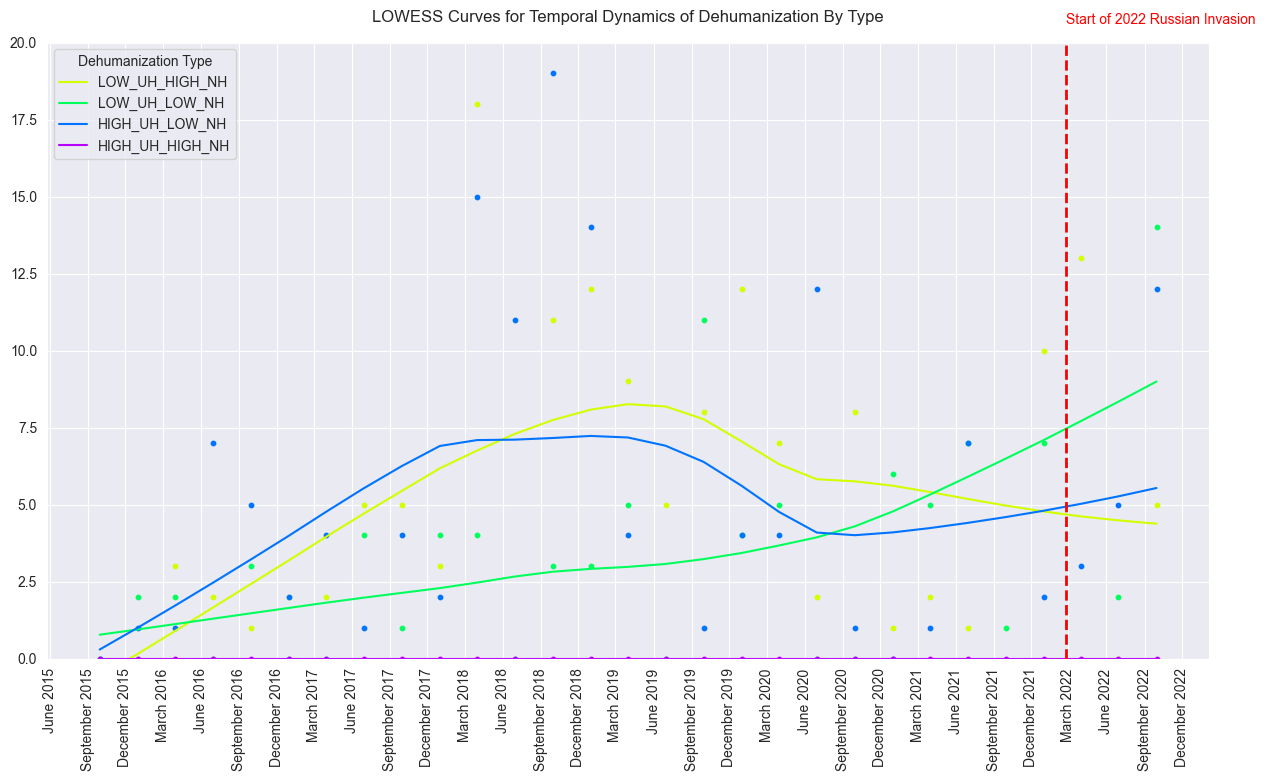

In [595]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import dates
from statsmodels.nonparametric.smoothers_lowess import lowess
import numpy as np

columns_to_plot = entities_list
df_predicted_data_merged_ = df_predicted_data_merged[columns_to_plot].copy()

df_monthly = df_predicted_data_merged_.resample('3M').sum().copy()

# Subset data up to 25th November 2022
df_monthly = df_monthly[df_monthly.index <= '2022-11-25'].copy()

# N = 5
# df_monthly_rolling = df_monthly.rolling(window=N).mean()

df_melted = df_monthly.reset_index().melt('date', var_name='a', value_name='b').copy()

plt.figure(figsize=(15, 8))

colors = sns.color_palette("hsv", len(entities_list))

for i, entity in enumerate(entities_list):
    entity_data = df_melted[df_melted['a'] == entity].copy()

    # Convert date into numerical format for LOWESS
    entity_data['date_num'] = np.arange(len(entity_data))

    # Apply lowess smoother
    smoothed = lowess(entity_data['b'], entity_data['date_num'])

    # Plot lowess smoothed data
    plt.plot(entity_data['date'], smoothed[:, 1], color=colors[i], label=entity)

    # Scatter plot of original data
    plt.scatter(entity_data['date'], entity_data['b'], color=colors[i], s=10)

ax = plt.gca()
ax.xaxis.set_major_locator(dates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(dates.DateFormatter('%B %Y'))
plt.xticks(rotation=90)

line_date = pd.to_datetime('2022-02-24')
plt.axvline(line_date, color='r', linestyle='--', lw=2)

offset_y = ax.get_ylim()[1]*0.63
plt.text(line_date, ax.get_ylim()[1] - offset_y, 'Start of 2022 Russian Invasion', color='red')

plt.title('LOWESS Curves for Temporal Dynamics of Dehumanization By Type', y=1.02)

plt.legend(title='Dehumanization Type')
plt.ylim(0, 20)

plt.show()


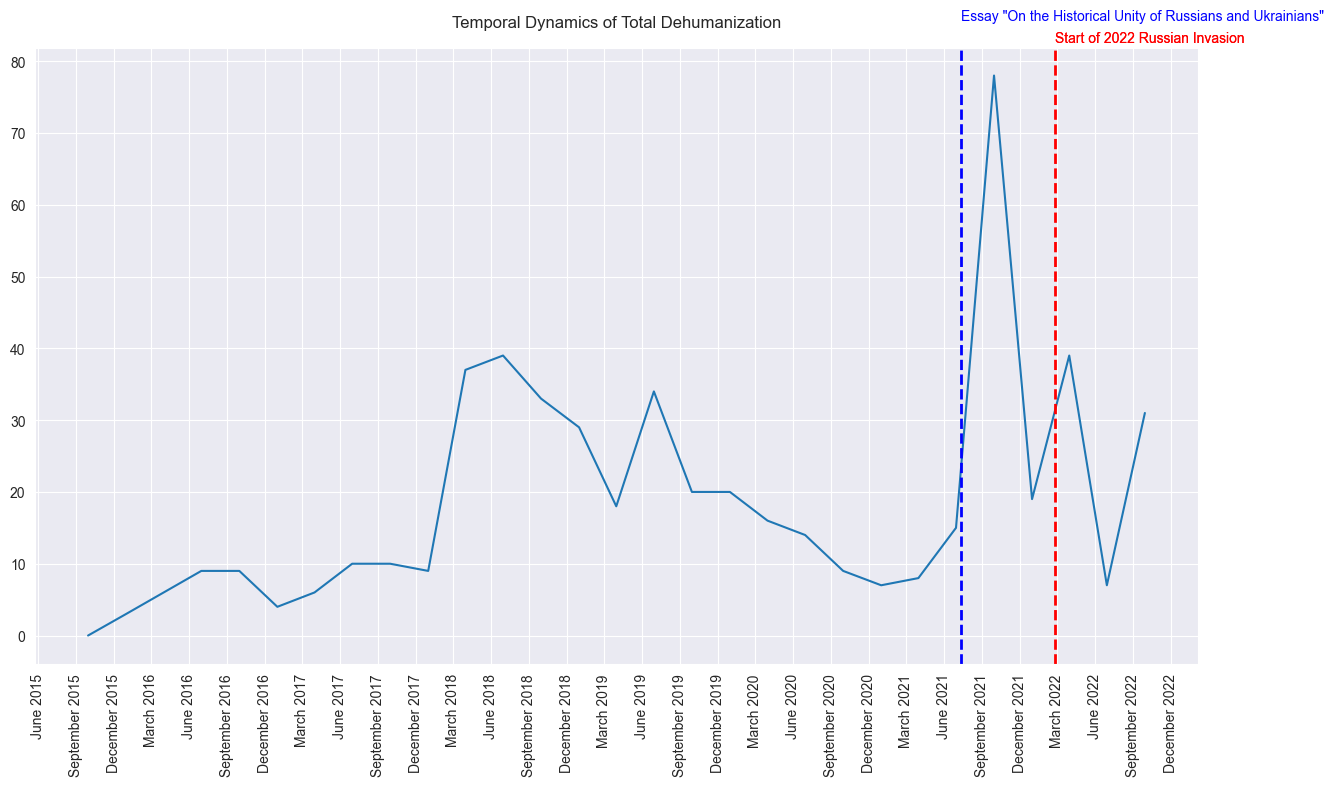

In [642]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import dates

columns_to_plot = ['LOW_UH_HIGH_NH', 'LOW_UH_LOW_NH', 'HIGH_UH_LOW_NH', 'HIGH_UH_HIGH_NH']
df_predicted_data_merged_ = df_predicted_data_merged[columns_to_plot].copy()

df_monthly = df_predicted_data_merged_.resample('3M').sum()

# Subset data up to 25th November 2022
df_monthly = df_monthly[df_monthly.index <= '2022-11-25']

N = 1
df_monthly_rolling = df_monthly.rolling(window=N).mean()

# Sum all the columns for each date
df_monthly_sum = df_monthly_rolling.sum(axis=1)

# Plotting the data
plt.figure(figsize=(15, 8))
sns.lineplot(x=df_monthly_sum.index, y=df_monthly_sum.values)
plt.title('Temporal Dynamics of Total Dehumanization', y=1.02)
plt.xlabel('')

# x-axis formatting
ax = plt.gca()
ax.xaxis.set_major_locator(dates.MonthLocator(interval=3))  # set the tick interval to 3 months
ax.xaxis.set_major_formatter(dates.DateFormatter('%B %Y'))  # set the date format to 'Month Year'
plt.xticks(rotation=90)

# Adding vertical line
line_date = pd.to_datetime('2022-02-24')
plt.axvline(line_date, color='r', linestyle='--', lw=2)
#
line_date2 = pd.to_datetime('2021-07-12')
plt.axvline(line_date2, color='b', linestyle='--', lw=2)

offset_y = ax.get_ylim()[1] * 0.01
plt.text(line_date, ax.get_ylim()[1] + offset_y, 'Start of 2022 Russian Invasion', color='red')
plt.text(line_date2, ax.get_ylim()[1]+ offset_y+3, 'Essay "On the Historical Unity of Russians and Ukrainians"', color='blue')

# Adding text label
offset_y = ax.get_ylim()[1] * 0.01
plt.text(line_date, ax.get_ylim()[1] + offset_y, 'Start of 2022 Russian Invasion', color='red')

plt.show()


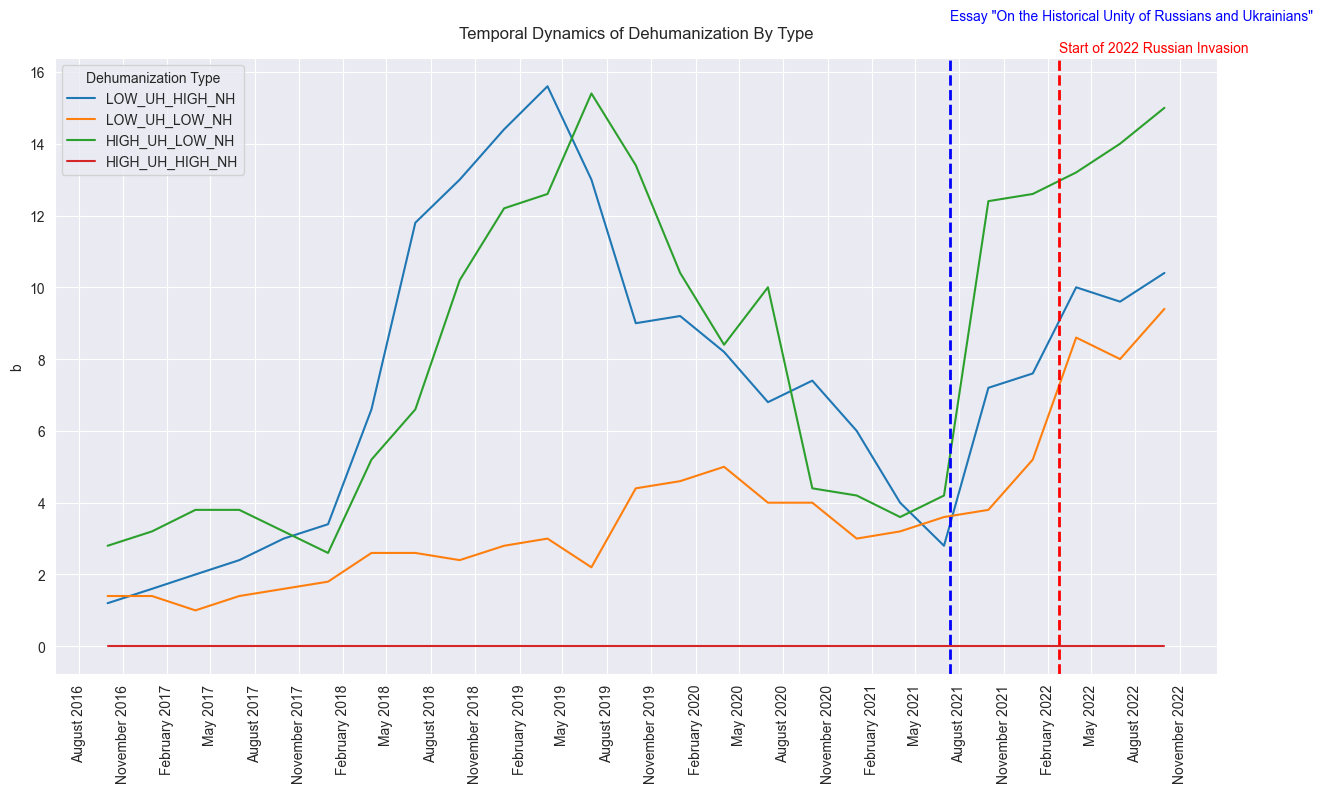

In [659]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import dates

columns_to_plot = entities_list
df_predicted_data_merged_ = df_predicted_data_merged[columns_to_plot].copy()

df_monthly = df_predicted_data_merged_.resample('3M').sum()

# Subset data up to 25th November 2022
df_monthly = df_monthly[df_monthly.index <= '2022-11-25']

N = 5
df_monthly_rolling = df_monthly.rolling(window=N).mean()

df_melted = df_monthly_rolling.reset_index().melt('date', var_name='a', value_name='b')

plt.figure(figsize=(15, 8))
plot = sns.lineplot(data=df_melted, x="date", y="b", hue="a")
plot.set_xlabel('')

ax = plt.gca()
ax.xaxis.set_major_locator(dates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(dates.DateFormatter('%B %Y'))
plt.xticks(rotation=90)

line_date = pd.to_datetime('2022-02-24')
plt.axvline(line_date, color='r', linestyle='--', lw=2)
#
line_date2 = pd.to_datetime('2021-07-12')
plt.axvline(line_date2, color='b', linestyle='--', lw=2)

offset_y = ax.get_ylim()[1] * 0.01
plt.text(line_date, ax.get_ylim()[1] + offset_y, 'Start of 2022 Russian Invasion', color='red')
plt.text(line_date2, ax.get_ylim()[1]+ offset_y+0.9, 'Essay "On the Historical Unity of Russians and Ukrainians"', color='blue')


plt.title('Temporal Dynamics of Dehumanization By Type', y=1.02)

leg = ax.legend()
leg.set_title('Dehumanization Type')

plt.show()

 ## Concept vector distance

In [524]:
import os
import glob

def read_all_files(directory):
    files = glob.glob(os.path.join(directory, '*.txt'))
    lists_dict = {}
    for file in files:
        with open(file, 'r') as f:
            content = f.read()
            list = content.split(',')
            list = [item.strip(' ') for item in list]
            filename = os.path.splitext(os.path.basename(file))[0]  # Extract filename without extension
            lists_dict[filename] = list
    return lists_dict

In [525]:
lists_dict = read_all_files('/Users/katerynaburovova/PycharmProjects/dehumanization/lexicons/NRC_VAD_ru')

In [528]:
lists_dict.keys()

dict_keys(['joyrus', 'fearrus', 'positiverus', 'negativerus', 'sadnessrus', 'disgustrus', 'surpriserus', 'angerrus', 'anticipationrus', 'trustrus'])

In [621]:
from gensim.models import Word2Vec
from matplotlib.ticker import MaxNLocator


def plot_denotation_divergence_concept_vec(ax, term_one, term_two, models_path, epochs, concept, window):
    terms_one = get_word_forms(term_one)
    terms_two = get_word_forms(term_two)
    print(terms_one)
    print('*'*80)
    print(terms_two[:20])
    distance_list = []
    time_periods = []

    model_files = sorted(os.listdir(models_path), key=lambda x: extract_time_period(x)[0] if x.endswith('.model') else '')

    for model_name in model_files:
        if not model_name.endswith('.model'):
            continue

        start_date, end_date = extract_time_period(model_name)
        if not start_date or not end_date:
            continue

        model_path = os.path.join(models_path, model_name)
        model = Word2Vec.load(model_path)
        model = zerocenter_normalize(model)

        centroid1 = get_centroid(terms_one, model)
        centroid2 = get_centroid(terms_two, model)

        if centroid1 is None or centroid2 is None:
            continue

        distance = calculate_distance(centroid1, centroid2)
        distance_list.append(distance)
        time_periods.append(f'{start_date[:4]}')

    weights = np.repeat(1.0, window_size) / window_size
    smoothed_distances = np.convolve(distance_list, weights, 'valid')

    ax.plot(smoothed_distances)

    xticks_labels = [year if i%4==0 else '' for i, year in enumerate(time_periods[window_size-1:])]

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_xticks(range(len(smoothed_distances)))
    ax.set_xticklabels(xticks_labels, rotation=90)
    ax.set_xlabel('Time Periods')
    ax.set_ylabel('Smoothed Cosine distance')
    ax.set_title('Distance between {} and {}, {} epochs'.format(term_one, concept, epochs))


def plot_all_concept(term_one, term_two, concept, window = 3):

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    plot_denotation_divergence_concept_vec(axs[0], term_one, term_two, models_path_few_epoch, 5, concept, window)
    plot_denotation_divergence_concept_vec(axs[1], term_one, term_two, models_path, 10, concept, window)

    plt.tight_layout()
    plt.show()

['—É–∫—Ä–∞–∏–Ω—Ü–∞', '—É–∫—Ä–∞–∏–Ω—Ü–µ', '—É–∫—Ä–∞–∏–Ω—Ü–µ–≤', '—É–∫—Ä–∞–∏–Ω—Ü–µ–º', '—É–∫—Ä–∞–∏–Ω–µ—Ü', '—É–∫—Ä–∞–∏–Ω—Ü–∞–º–∏', '—É–∫—Ä–∞–∏–Ω—Ü–∞—Ö', '—É–∫—Ä–∞–∏–Ω—Ü—É', '—É–∫—Ä–∞–∏–Ω—Ü–∞–º', '—É–∫—Ä–∞–∏–Ω—Ü—ã']
********************************************************************************
['', '—à–∞–Ω—Ç–∞–∂–∏—Ä–æ–≤–∞–Ω–Ω—ã–µ', '–ø—Ä–∞–≤—è—â—É—é', '–Ω–∞–∏–æ–ø–∞—Å–Ω–µ–π—à–∏–º–∏', '–¥–∏—Å–∫—Ä–∏–º–∏–Ω–∞—Ü–∏—è', '–æ—Ç—Å—É—Ç—Å—Ç–≤—É–π—Ç–µ', '–ø–æ—Ö–æ—Ä–æ–Ω–∏–≤—à–µ–µ', '–∫–æ—Ä–∞–±–ª–µ–∫—Ä—É—à–µ–Ω—å—è—Ö', '—Ä–∞–∑—Ä—É—à–∏—Ç–µ–ª–µ', '–Ω–∞–∫–∞–∑–∞–Ω–Ω–∞—è', '–≥—Ä—É–±–æ—Å—Ç—å', '–∑–∞–≥–∞–¥–æ—á–Ω–æ–µ', '—Ö–ª–æ–ø–∞–µ–º—ã–µ', '–≤—Ä–∞–≥–æ–º', '–Ω–∞–∏–ø–æ–¥–ª–µ–π—à–µ–≥–æ', '–¥–µ–ø–æ—Ä—Ç–∏—Ä—É–µ–º—ã—Ö', '–∑–∞–≥–∞–¥–æ—á–Ω–∞', '–±—Ä–æ–Ω–∏—Ä—É–µ–º—ã–π', '—É–±–µ–∂–∏—â', '–ø—Ä–∏—á–∏–Ω—è—Ç—å']
['—É–∫—Ä–∞–∏–Ω—Ü–∞', '—É–∫—Ä–∞–∏–Ω—Ü–µ', '—É–∫—Ä–∞–∏–Ω—Ü–µ–≤', '—É–∫—Ä–∞–∏–Ω—Ü–µ–º', '—É–∫—Ä–∞–∏–Ω–µ—Ü', '—É–∫—Ä–∞–∏–Ω—Ü–∞–º–∏', '—É–∫—Ä–∞–∏–Ω—Ü–∞—Ö', '—É–∫—Ä–∞–∏–Ω—Ü—É', '—É–∫—Ä–∞–∏–Ω—Ü–∞–º', '—É–∫—Ä–∞–∏–Ω—Ü—ã']
**

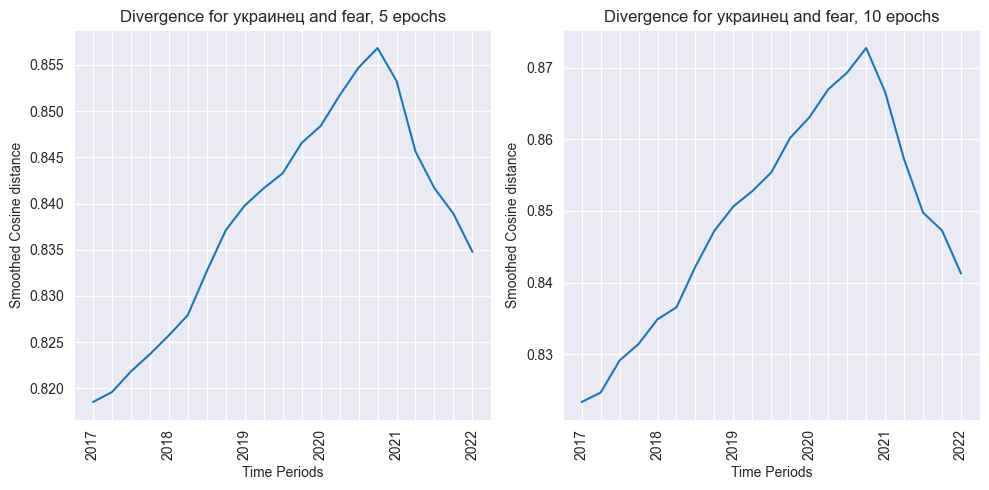

CPU times: user 2min 53s, sys: 31.2 s, total: 3min 24s
Wall time: 3min 41s


In [620]:
%%time
plot_all_concept('—É–∫—Ä–∞–∏–Ω–µ—Ü', lists_dict['fearrus'], 'fear')

['—É–∫—Ä–∞–∏–Ω—Ü–∞', '—É–∫—Ä–∞–∏–Ω—Ü–µ', '—É–∫—Ä–∞–∏–Ω—Ü–µ–≤', '—É–∫—Ä–∞–∏–Ω—Ü–µ–º', '—É–∫—Ä–∞–∏–Ω–µ—Ü', '—É–∫—Ä–∞–∏–Ω—Ü–∞–º–∏', '—É–∫—Ä–∞–∏–Ω—Ü–∞—Ö', '—É–∫—Ä–∞–∏–Ω—Ü—É', '—É–∫—Ä–∞–∏–Ω—Ü–∞–º', '—É–∫—Ä–∞–∏–Ω—Ü—ã']
********************************************************************************
['', '–¥–∏—Å–∫—Ä–∏–º–∏–Ω–∞—Ü–∏—è', '—Ç–æ—à–Ω–æ—Ç—ã', '–≤–æ—Ä—á–∞–ª–∞', '–ø–æ–Ω–µ–ø—Ä–æ—Å—Ç–∏—Ç–µ–ª—å–Ω–µ–µ', '–ø–æ–Ω–µ–ø–æ–∫–æ—Ä–Ω–µ–µ', '–∏–∑–≤—Ä–∞—Ç–∏—Ç', '–Ω–∞–∫–∞–∑–∞–Ω–Ω–∞—è', '–Ω–µ–ø—Ä–∏—Å—Ç–æ–π–Ω–æ–º—É', '–≤—Ä–∞–≥–æ–º', '–¥–µ—Ñ–µ–∫—Ç–Ω–æ–µ', '–Ω–∞–∏–ø–æ–¥–ª–µ–π—à–µ–≥–æ', '–ø–∞–¥–æ–Ω–∫–∞', '—Ä–∞–∑–¥—É–≤—à–µ–º', '–≤–æ–ª–æ—Å–∞—Ç–µ–π—à–µ–º', '—Ñ–ª–∏–≥–µ–ª—å', '—Ç–µ—Ä–º–∏—Ç—É', '—à—É–º–æ–≤', '–±–µ—Å—Å–º—ã—Å–ª–µ–Ω–Ω–µ–π—à–∏—Ö', '–∂–µ–ª–∞—Ç–∏–Ω–µ']
['—É–∫—Ä–∞–∏–Ω—Ü–∞', '—É–∫—Ä–∞–∏–Ω—Ü–µ', '—É–∫—Ä–∞–∏–Ω—Ü–µ–≤', '—É–∫—Ä–∞–∏–Ω—Ü–µ–º', '—É–∫—Ä–∞–∏–Ω–µ—Ü', '—É–∫—Ä–∞–∏–Ω—Ü–∞–º–∏', '—É–∫—Ä–∞–∏–Ω—Ü–∞—Ö', '—É–∫—Ä–∞–∏–Ω—Ü—É', '—É–∫—Ä–∞–∏–Ω—Ü–∞–º', '—É–∫—Ä–∞–∏–Ω—Ü—ã']
****************************************

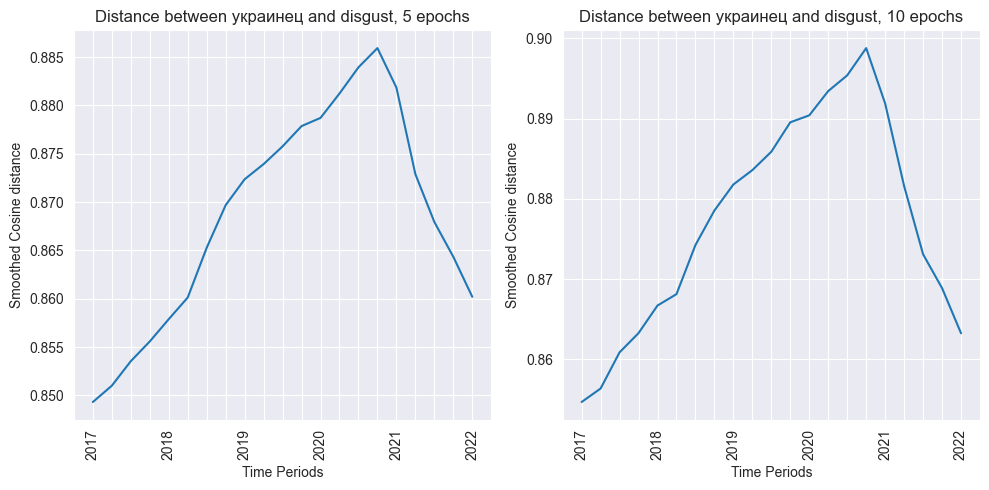

CPU times: user 2min 53s, sys: 33.1 s, total: 3min 26s
Wall time: 3min 46s


In [622]:
%%time
plot_all_concept('—É–∫—Ä–∞–∏–Ω–µ—Ü', lists_dict['disgustrus'], 'disgust')

['—É–∫—Ä–∞–∏–Ω—Ü–∞', '—É–∫—Ä–∞–∏–Ω—Ü–µ', '—É–∫—Ä–∞–∏–Ω—Ü–µ–≤', '—É–∫—Ä–∞–∏–Ω—Ü–µ–º', '—É–∫—Ä–∞–∏–Ω–µ—Ü', '—É–∫—Ä–∞–∏–Ω—Ü–∞–º–∏', '—É–∫—Ä–∞–∏–Ω—Ü–∞—Ö', '—É–∫—Ä–∞–∏–Ω—Ü—É', '—É–∫—Ä–∞–∏–Ω—Ü–∞–º', '—É–∫—Ä–∞–∏–Ω—Ü—ã']
********************************************************************************
['', '—à–∞–Ω—Ç–∞–∂–∏—Ä–æ–≤–∞–Ω–Ω—ã–µ', '–¥–∏—Å–∫—Ä–∏–º–∏–Ω–∞—Ü–∏—è', '—Å–≤–∞–ª–∫–∞—Ö', '–≤–æ—Ä—á–∞–ª–∞', '–ø–æ–Ω–µ–ø—Ä–æ—Å—Ç–∏—Ç–µ–ª—å–Ω–µ–µ', '–ø–æ–Ω–µ–ø–æ–∫–æ—Ä–Ω–µ–µ', '—Ä–∞–∑—Ä—É—à–∏—Ç–µ–ª–µ', '–Ω–∞–∫–∞–∑–∞–Ω–Ω–∞—è', '–≥—Ä—É–±–æ—Å—Ç—å', '—Ö–ª–æ–ø–∞–µ–º—ã–µ', '–≤—Ä–∞–≥–æ–º', '–Ω–∞–∏–ø–æ–¥–ª–µ–π—à–µ–≥–æ', '–æ—Ç–º–µ–Ω—è–µ–º', '–ø—Ä–∏—á–∏–Ω—è—Ç—å', '–∑–∞—â–∏—Ç—É', '—à—É–º–æ–≤', '–±–µ—Å—Å–º—ã—Å–ª–µ–Ω–Ω–µ–π—à–∏—Ö', '–≥–∞—à–µ–Ω–Ω—ã–º–∏', '—Ö–∏—â–Ω–æ']
['—É–∫—Ä–∞–∏–Ω—Ü–∞', '—É–∫—Ä–∞–∏–Ω—Ü–µ', '—É–∫—Ä–∞–∏–Ω—Ü–µ–≤', '—É–∫—Ä–∞–∏–Ω—Ü–µ–º', '—É–∫—Ä–∞–∏–Ω–µ—Ü', '—É–∫—Ä–∞–∏–Ω—Ü–∞–º–∏', '—É–∫—Ä–∞–∏–Ω—Ü–∞—Ö', '—É–∫—Ä–∞–∏–Ω—Ü—É', '—É–∫—Ä–∞–∏–Ω—Ü–∞–º', '—É–∫—Ä–∞–∏–Ω—Ü—ã']
****************************************

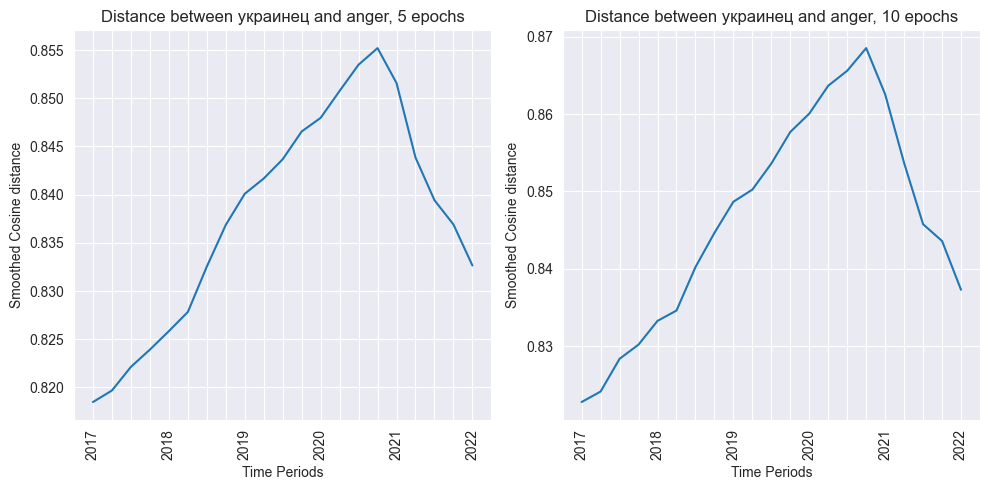

CPU times: user 2min 56s, sys: 37.8 s, total: 3min 34s
Wall time: 4min 1s


In [624]:
%%time
plot_all_concept('—É–∫—Ä–∞–∏–Ω–µ—Ü', lists_dict['angerrus'], 'anger')

['—É–∫—Ä–∞–∏–Ω—Ü–∞', '—É–∫—Ä–∞–∏–Ω—Ü–µ', '—É–∫—Ä–∞–∏–Ω—Ü–µ–≤', '—É–∫—Ä–∞–∏–Ω—Ü–µ–º', '—É–∫—Ä–∞–∏–Ω–µ—Ü', '—É–∫—Ä–∞–∏–Ω—Ü–∞–º–∏', '—É–∫—Ä–∞–∏–Ω—Ü–∞—Ö', '—É–∫—Ä–∞–∏–Ω—Ü—É', '—É–∫—Ä–∞–∏–Ω—Ü–∞–º', '—É–∫—Ä–∞–∏–Ω—Ü—ã']
********************************************************************************
['', '–Ω–∞–∏–æ–ø–∞—Å–Ω–µ–π—à–∏–º–∏', '–¥–∏—Å–∫—Ä–∏–º–∏–Ω–∞—Ü–∏—è', '—Å–≤–∞–ª–∫–∞—Ö', '–æ—Ç—Å—É—Ç—Å—Ç–≤—É–π—Ç–µ', '–ø–æ—Ö–æ—Ä–æ–Ω–∏–≤—à–µ–µ', '–∫–æ—Ä–∞–±–ª–µ–∫—Ä—É—à–µ–Ω—å—è—Ö', '–ø–æ–Ω–µ–ø—Ä–æ—Å—Ç–∏—Ç–µ–ª—å–Ω–µ–µ', '–Ω–∞–∫–∞–∑–∞–Ω–Ω–∞—è', '–ø–æ–Ω–µ—Å–ø–æ—Å–æ–±–Ω–µ–π', '–≤—ã–ª–µ—Ç –∏–∑—à–∞—è', '–¥–µ–ø–æ—Ä—Ç–∏—Ä—É–µ–º—ã—Ö', '–ø–æ—Ç–µ—Ä—è–Ω–Ω–æ–µ', '–∞–ø–∞—Ç–∏—á–Ω—ã–º', '–ø—Ä–∏—á–∏–Ω—è—Ç—å', '–±–µ—Å—Å–º—ã—Å–ª–µ–Ω–Ω–µ–π—à–∏—Ö', '—Å–ø–æ–π–ª–µ—Ä–∞–º–∏', '—Ö–∏—â–Ω–æ', '–Ω–µ–≤–Ω–∏–º–∞—Ç–µ–ª—å–Ω—ã–µ', '—Å–∫–æ—Ä–±–∏—à—å']
['—É–∫—Ä–∞–∏–Ω—Ü–∞', '—É–∫—Ä–∞–∏–Ω—Ü–µ', '—É–∫—Ä–∞–∏–Ω—Ü–µ–≤', '—É–∫—Ä–∞–∏–Ω—Ü–µ–º', '—É–∫—Ä–∞–∏–Ω–µ—Ü', '—É–∫—Ä–∞–∏–Ω—Ü–∞–º–∏', '—É–∫—Ä–∞–∏–Ω—Ü–∞—Ö', '—É–∫—Ä–∞–∏–Ω—Ü—É', '—É–∫—Ä–∞–∏–Ω—Ü–∞

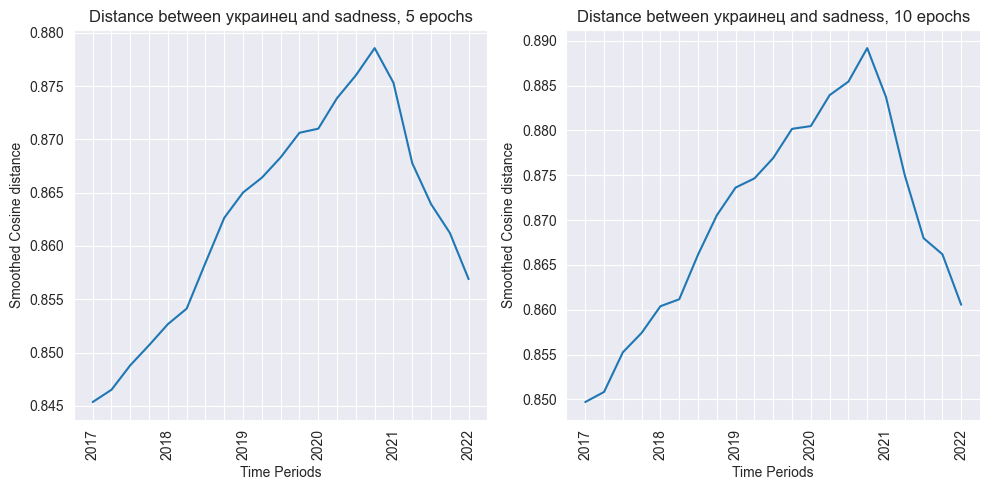

CPU times: user 2min 57s, sys: 33.7 s, total: 3min 31s
Wall time: 3min 53s


In [625]:
%%time
plot_all_concept('—É–∫—Ä–∞–∏–Ω–µ—Ü', lists_dict['sadnessrus'], 'sadness')

['—É–∫—Ä–∞–∏–Ω—Ü–∞', '—É–∫—Ä–∞–∏–Ω—Ü–µ', '—É–∫—Ä–∞–∏–Ω—Ü–µ–≤', '—É–∫—Ä–∞–∏–Ω—Ü–µ–º', '—É–∫—Ä–∞–∏–Ω–µ—Ü', '—É–∫—Ä–∞–∏–Ω—Ü–∞–º–∏', '—É–∫—Ä–∞–∏–Ω—Ü–∞—Ö', '—É–∫—Ä–∞–∏–Ω—Ü—É', '—É–∫—Ä–∞–∏–Ω—Ü–∞–º', '—É–∫—Ä–∞–∏–Ω—Ü—ã']
********************************************************************************
['', '–ø—Ä–∞–≤—è—â—É—é', '—Ä–∞–∑—ä—è—Å–Ω—ë–Ω–Ω—ã–º–∏', '–ø–æ—á—Ç–µ–Ω–∏—è—Ö', '–ø–æ—Å–º–µ–∏–≤–∞—é—Ç—Å—è', '–ø–æ—Ä—É—á–µ–Ω–∏—è—Ö', '–æ–±–Ω–∏–º–∞—é—â–µ–π', '—Å–æ—Å—Ç–∞–≤–ª—è–µ–º', '–ø—Ä–∏—Ö–æ–¥–æ–º', '—Å–ø–ª–æ—á–µ–Ω–∞', '–≤—ã–∑–¥–æ—Ä–æ–≤–ª–µ–Ω–∏–µ', '–æ–∂–∏–≤–∏–º', '–¥–æ–ø–æ–ª–Ω—è–µ–º–∞', '–ø–æ–ª—É–ª–µ–∂–∞–≤—à–µ–º', '–Ω–∞–ø–æ–ª–Ω—è—é—â–µ–π', '–Ω–∞–∫–ª–æ–Ω—è–µ—à—å', '–∑–∞—â–∏—Ç—É', '—Å—Ç–æ—Ä–æ–∂–∞—â–µ–º—É', '—É–º–Ω–µ–π—à–µ–º', '–º–æ–Ω–æ–≥–∞–º–∏—è—Ö']
['—É–∫—Ä–∞–∏–Ω—Ü–∞', '—É–∫—Ä–∞–∏–Ω—Ü–µ', '—É–∫—Ä–∞–∏–Ω—Ü–µ–≤', '—É–∫—Ä–∞–∏–Ω—Ü–µ–º', '—É–∫—Ä–∞–∏–Ω–µ—Ü', '—É–∫—Ä–∞–∏–Ω—Ü–∞–º–∏', '—É–∫—Ä–∞–∏–Ω—Ü–∞—Ö', '—É–∫—Ä–∞–∏–Ω—Ü—É', '—É–∫—Ä–∞–∏–Ω—Ü–∞–º', '—É–∫—Ä–∞–∏–Ω—Ü—ã']
******************************************

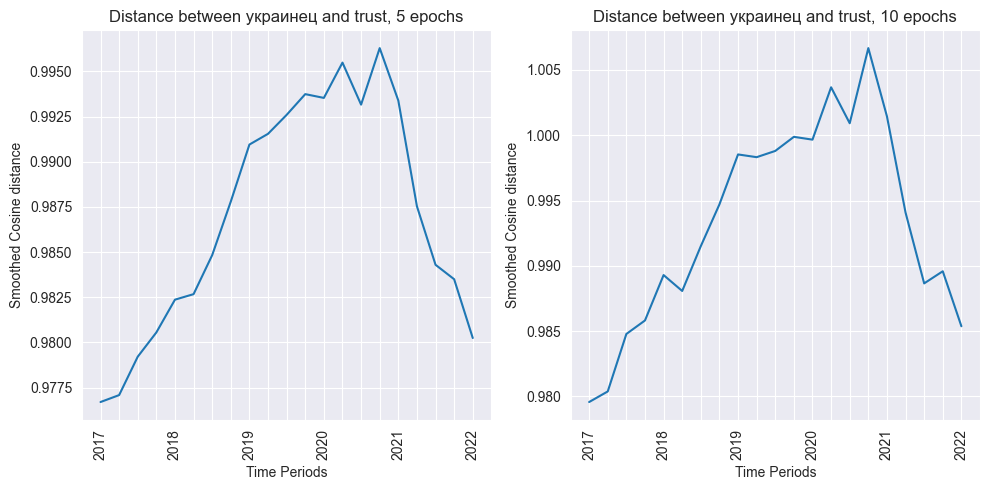

CPU times: user 2min 55s, sys: 30.4 s, total: 3min 25s
Wall time: 3min 41s


In [626]:
%%time
plot_all_concept('—É–∫—Ä–∞–∏–Ω–µ—Ü', lists_dict['trustrus'], 'trust')

['—Ö–æ—Ö–ª–æ–º', '—Ö–æ—Ö–ª–æ–≤', '—Ö–æ—Ö–ª–∞', '—Ö–æ—Ö–ª—É', '—Ö–æ—Ö–ª–∞–º', '—Ö–æ—Ö–ª—ã', '—Ö–æ—Ö–ª–∞—Ö', '—Ö–æ—Ö–æ–ª', '—Ö–æ—Ö–ª–µ', '—Ö–æ—Ö–ª–∞–º–∏']
********************************************************************************
['', '–¥–∏—Å–∫—Ä–∏–º–∏–Ω–∞—Ü–∏—è', '—Ç–æ—à–Ω–æ—Ç—ã', '–≤–æ—Ä—á–∞–ª–∞', '–ø–æ–Ω–µ–ø—Ä–æ—Å—Ç–∏—Ç–µ–ª—å–Ω–µ–µ', '–ø–æ–Ω–µ–ø–æ–∫–æ—Ä–Ω–µ–µ', '–∏–∑–≤—Ä–∞—Ç–∏—Ç', '–Ω–∞–∫–∞–∑–∞–Ω–Ω–∞—è', '–Ω–µ–ø—Ä–∏—Å—Ç–æ–π–Ω–æ–º—É', '–≤—Ä–∞–≥–æ–º', '–¥–µ—Ñ–µ–∫—Ç–Ω–æ–µ', '–Ω–∞–∏–ø–æ–¥–ª–µ–π—à–µ–≥–æ', '–ø–∞–¥–æ–Ω–∫–∞', '—Ä–∞–∑–¥—É–≤—à–µ–º', '–≤–æ–ª–æ—Å–∞—Ç–µ–π—à–µ–º', '—Ñ–ª–∏–≥–µ–ª—å', '—Ç–µ—Ä–º–∏—Ç—É', '—à—É–º–æ–≤', '–±–µ—Å—Å–º—ã—Å–ª–µ–Ω–Ω–µ–π—à–∏—Ö', '–∂–µ–ª–∞—Ç–∏–Ω–µ']
['—Ö–æ—Ö–ª–æ–º', '—Ö–æ—Ö–ª–æ–≤', '—Ö–æ—Ö–ª–∞', '—Ö–æ—Ö–ª—É', '—Ö–æ—Ö–ª–∞–º', '—Ö–æ—Ö–ª—ã', '—Ö–æ—Ö–ª–∞—Ö', '—Ö–æ—Ö–æ–ª', '—Ö–æ—Ö–ª–µ', '—Ö–æ—Ö–ª–∞–º–∏']
********************************************************************************
['', '–¥–∏—Å–∫—Ä–∏–º–∏–Ω–∞—Ü–∏—è', '—Ç–æ—à–Ω–æ—Ç—ã', '–≤–æ—Ä—á–∞–ª–∞', '–ø–æ–Ω–

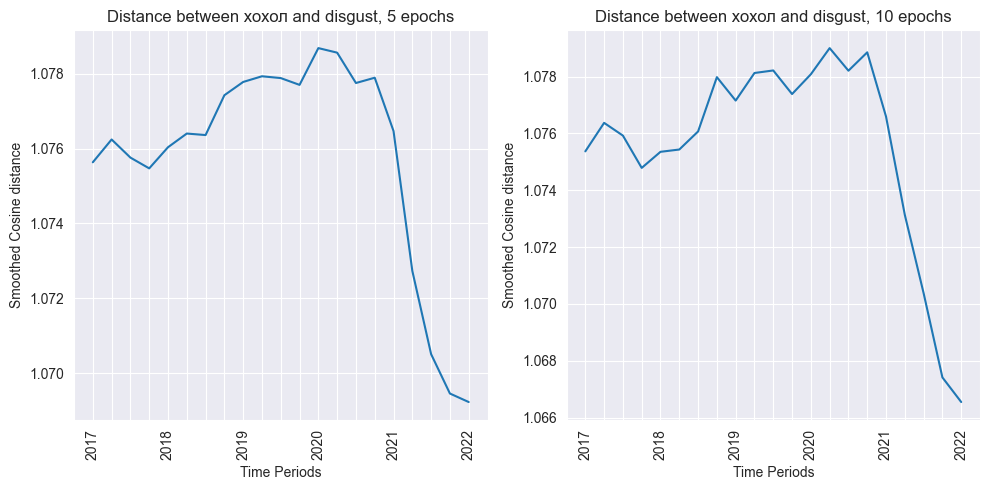

CPU times: user 2min 50s, sys: 30.1 s, total: 3min 20s
Wall time: 3min 37s


In [623]:
%%time
plot_all_concept('—Ö–æ—Ö–æ–ª', lists_dict['disgustrus'], 'disgust')

['—Ö–æ—Ö–ª–æ–º', '—Ö–æ—Ö–ª–æ–≤', '—Ö–æ—Ö–ª–∞', '—Ö–æ—Ö–ª—É', '—Ö–æ—Ö–ª–∞–º', '—Ö–æ—Ö–ª—ã', '—Ö–æ—Ö–ª–∞—Ö', '—Ö–æ—Ö–æ–ª', '—Ö–æ—Ö–ª–µ', '—Ö–æ—Ö–ª–∞–º–∏']
********************************************************************************
['', '—à–∞–Ω—Ç–∞–∂–∏—Ä–æ–≤–∞–Ω–Ω—ã–µ', '–ø—Ä–∞–≤—è—â—É—é', '–Ω–∞–∏–æ–ø–∞—Å–Ω–µ–π—à–∏–º–∏', '–¥–∏—Å–∫—Ä–∏–º–∏–Ω–∞—Ü–∏—è', '–æ—Ç—Å—É—Ç—Å—Ç–≤—É–π—Ç–µ', '–ø–æ—Ö–æ—Ä–æ–Ω–∏–≤—à–µ–µ', '–∫–æ—Ä–∞–±–ª–µ–∫—Ä—É—à–µ–Ω—å—è—Ö', '—Ä–∞–∑—Ä—É—à–∏—Ç–µ–ª–µ', '–Ω–∞–∫–∞–∑–∞–Ω–Ω–∞—è', '–≥—Ä—É–±–æ—Å—Ç—å', '–∑–∞–≥–∞–¥–æ—á–Ω–æ–µ', '—Ö–ª–æ–ø–∞–µ–º—ã–µ', '–≤—Ä–∞–≥–æ–º', '–Ω–∞–∏–ø–æ–¥–ª–µ–π—à–µ–≥–æ', '–¥–µ–ø–æ—Ä—Ç–∏—Ä—É–µ–º—ã—Ö', '–∑–∞–≥–∞–¥–æ—á–Ω–∞', '–±—Ä–æ–Ω–∏—Ä—É–µ–º—ã–π', '—É–±–µ–∂–∏—â', '–ø—Ä–∏—á–∏–Ω—è—Ç—å']
['—Ö–æ—Ö–ª–æ–º', '—Ö–æ—Ö–ª–æ–≤', '—Ö–æ—Ö–ª–∞', '—Ö–æ—Ö–ª—É', '—Ö–æ—Ö–ª–∞–º', '—Ö–æ—Ö–ª—ã', '—Ö–æ—Ö–ª–∞—Ö', '—Ö–æ—Ö–æ–ª', '—Ö–æ—Ö–ª–µ', '—Ö–æ—Ö–ª–∞–º–∏']
********************************************************************************
['', '—à–∞–Ω—Ç–∞–∂–∏—Ä–æ–≤–∞–Ω–Ω—ã–µ', '–

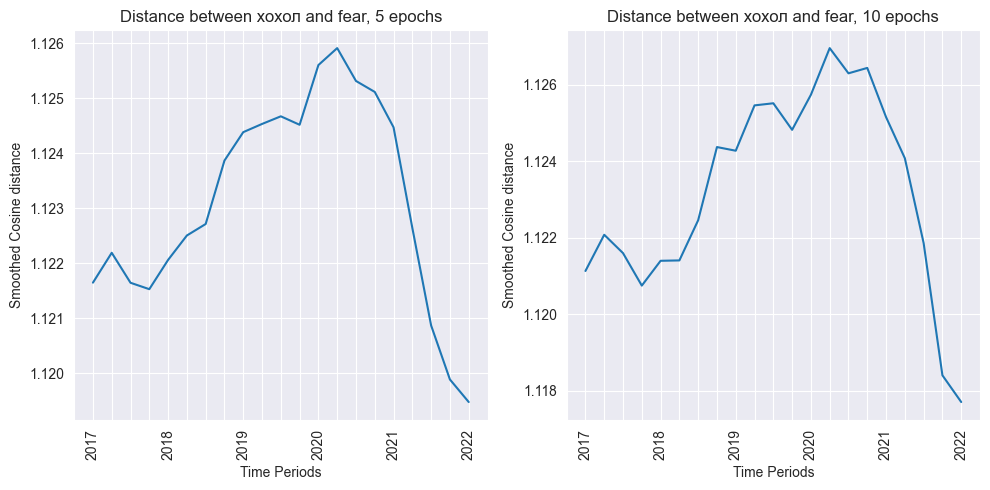

CPU times: user 2min 53s, sys: 32.9 s, total: 3min 26s
Wall time: 3min 46s


In [627]:
%%time
plot_all_concept('—Ö–æ—Ö–æ–ª', lists_dict['fearrus'], 'fear')

['—Ö–æ—Ö–ª–æ–º', '—Ö–æ—Ö–ª–æ–≤', '—Ö–æ—Ö–ª–∞', '—Ö–æ—Ö–ª—É', '—Ö–æ—Ö–ª–∞–º', '—Ö–æ—Ö–ª—ã', '—Ö–æ—Ö–ª–∞—Ö', '—Ö–æ—Ö–æ–ª', '—Ö–æ—Ö–ª–µ', '—Ö–æ—Ö–ª–∞–º–∏']
********************************************************************************
['', '–Ω–∞–∏–æ–ø–∞—Å–Ω–µ–π—à–∏–º–∏', '–¥–∏—Å–∫—Ä–∏–º–∏–Ω–∞—Ü–∏—è', '—Å–≤–∞–ª–∫–∞—Ö', '–æ—Ç—Å—É—Ç—Å—Ç–≤—É–π—Ç–µ', '–ø–æ—Ö–æ—Ä–æ–Ω–∏–≤—à–µ–µ', '–∫–æ—Ä–∞–±–ª–µ–∫—Ä—É—à–µ–Ω—å—è—Ö', '–ø–æ–Ω–µ–ø—Ä–æ—Å—Ç–∏—Ç–µ–ª—å–Ω–µ–µ', '–Ω–∞–∫–∞–∑–∞–Ω–Ω–∞—è', '–ø–æ–Ω–µ—Å–ø–æ—Å–æ–±–Ω–µ–π', '–≤—ã–ª–µ—Ç –∏–∑—à–∞—è', '–¥–µ–ø–æ—Ä—Ç–∏—Ä—É–µ–º—ã—Ö', '–ø–æ—Ç–µ—Ä—è–Ω–Ω–æ–µ', '–∞–ø–∞—Ç–∏—á–Ω—ã–º', '–ø—Ä–∏—á–∏–Ω—è—Ç—å', '–±–µ—Å—Å–º—ã—Å–ª–µ–Ω–Ω–µ–π—à–∏—Ö', '—Å–ø–æ–π–ª–µ—Ä–∞–º–∏', '—Ö–∏—â–Ω–æ', '–Ω–µ–≤–Ω–∏–º–∞—Ç–µ–ª—å–Ω—ã–µ', '—Å–∫–æ—Ä–±–∏—à—å']
['—Ö–æ—Ö–ª–æ–º', '—Ö–æ—Ö–ª–æ–≤', '—Ö–æ—Ö–ª–∞', '—Ö–æ—Ö–ª—É', '—Ö–æ—Ö–ª–∞–º', '—Ö–æ—Ö–ª—ã', '—Ö–æ—Ö–ª–∞—Ö', '—Ö–æ—Ö–æ–ª', '—Ö–æ—Ö–ª–µ', '—Ö–æ—Ö–ª–∞–º–∏']
********************************************************************************
['', '–Ω–∞–∏–æ

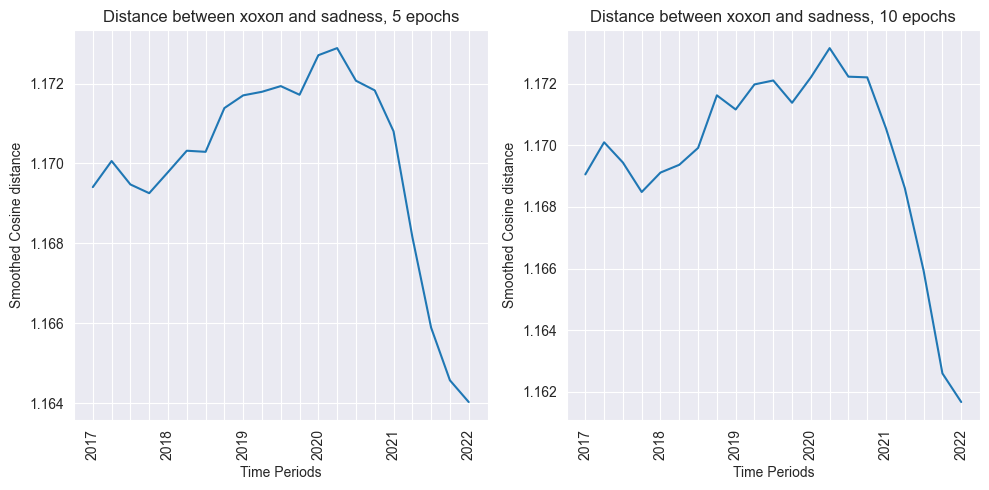

In [628]:
plot_all_concept('—Ö–æ—Ö–æ–ª', lists_dict['sadnessrus'], 'sadness')

['—Ö–æ—Ö–ª–æ–º', '—Ö–æ—Ö–ª–æ–≤', '—Ö–æ—Ö–ª–∞', '—Ö–æ—Ö–ª—É', '—Ö–æ—Ö–ª–∞–º', '—Ö–æ—Ö–ª—ã', '—Ö–æ—Ö–ª–∞—Ö', '—Ö–æ—Ö–æ–ª', '—Ö–æ—Ö–ª–µ', '—Ö–æ—Ö–ª–∞–º–∏']
********************************************************************************
['', '—à–∞–Ω—Ç–∞–∂–∏—Ä–æ–≤–∞–Ω–Ω—ã–µ', '–¥–∏—Å–∫—Ä–∏–º–∏–Ω–∞—Ü–∏—è', '—Å–≤–∞–ª–∫–∞—Ö', '–≤–æ—Ä—á–∞–ª–∞', '–ø–æ–Ω–µ–ø—Ä–æ—Å—Ç–∏—Ç–µ–ª—å–Ω–µ–µ', '–ø–æ–Ω–µ–ø–æ–∫–æ—Ä–Ω–µ–µ', '—Ä–∞–∑—Ä—É—à–∏—Ç–µ–ª–µ', '–Ω–∞–∫–∞–∑–∞–Ω–Ω–∞—è', '–≥—Ä—É–±–æ—Å—Ç—å', '—Ö–ª–æ–ø–∞–µ–º—ã–µ', '–≤—Ä–∞–≥–æ–º', '–Ω–∞–∏–ø–æ–¥–ª–µ–π—à–µ–≥–æ', '–æ—Ç–º–µ–Ω—è–µ–º', '–ø—Ä–∏—á–∏–Ω—è—Ç—å', '–∑–∞—â–∏—Ç—É', '—à—É–º–æ–≤', '–±–µ—Å—Å–º—ã—Å–ª–µ–Ω–Ω–µ–π—à–∏—Ö', '–≥–∞—à–µ–Ω–Ω—ã–º–∏', '—Ö–∏—â–Ω–æ']
['—Ö–æ—Ö–ª–æ–º', '—Ö–æ—Ö–ª–æ–≤', '—Ö–æ—Ö–ª–∞', '—Ö–æ—Ö–ª—É', '—Ö–æ—Ö–ª–∞–º', '—Ö–æ—Ö–ª—ã', '—Ö–æ—Ö–ª–∞—Ö', '—Ö–æ—Ö–æ–ª', '—Ö–æ—Ö–ª–µ', '—Ö–æ—Ö–ª–∞–º–∏']
********************************************************************************
['', '—à–∞–Ω—Ç–∞–∂–∏—Ä–æ–≤–∞–Ω–Ω—ã–µ', '–¥–∏—Å–∫—Ä–∏–º–∏–Ω–∞—Ü–∏—è', '—Å–≤–∞–ª–

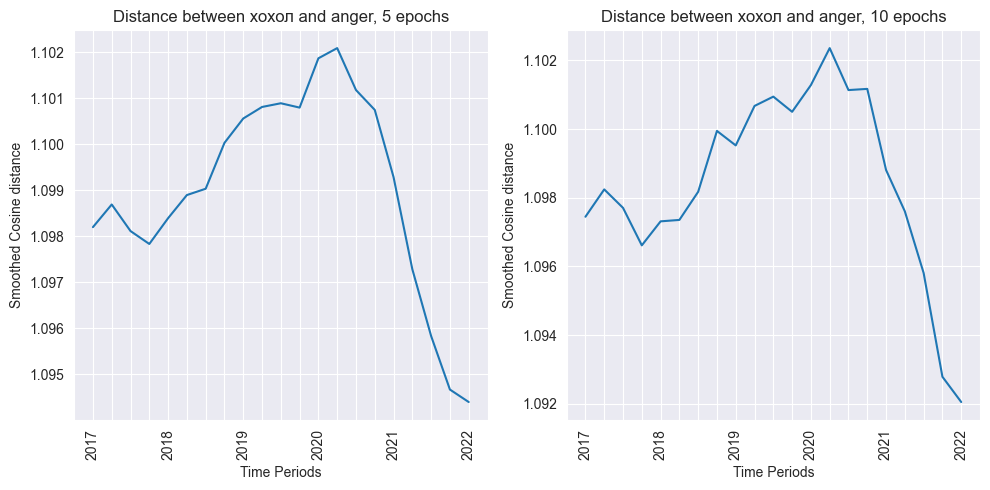

In [629]:
plot_all_concept('—Ö–æ—Ö–æ–ª', lists_dict['angerrus'], 'anger')

['—Ö–æ—Ö–ª–æ–º', '—Ö–æ—Ö–ª–æ–≤', '—Ö–æ—Ö–ª–∞', '—Ö–æ—Ö–ª—É', '—Ö–æ—Ö–ª–∞–º', '—Ö–æ—Ö–ª—ã', '—Ö–æ—Ö–ª–∞—Ö', '—Ö–æ—Ö–æ–ª', '—Ö–æ—Ö–ª–µ', '—Ö–æ—Ö–ª–∞–º–∏']
********************************************************************************
['', '–ø—Ä–∞–≤—è—â—É—é', '—Ä–∞–∑—ä—è—Å–Ω—ë–Ω–Ω—ã–º–∏', '–ø–æ—á—Ç–µ–Ω–∏—è—Ö', '–ø–æ—Å–º–µ–∏–≤–∞—é—Ç—Å—è', '–ø–æ—Ä—É—á–µ–Ω–∏—è—Ö', '–æ–±–Ω–∏–º–∞—é—â–µ–π', '—Å–æ—Å—Ç–∞–≤–ª—è–µ–º', '–ø—Ä–∏—Ö–æ–¥–æ–º', '—Å–ø–ª–æ—á–µ–Ω–∞', '–≤—ã–∑–¥–æ—Ä–æ–≤–ª–µ–Ω–∏–µ', '–æ–∂–∏–≤–∏–º', '–¥–æ–ø–æ–ª–Ω—è–µ–º–∞', '–ø–æ–ª—É–ª–µ–∂–∞–≤—à–µ–º', '–Ω–∞–ø–æ–ª–Ω—è—é—â–µ–π', '–Ω–∞–∫–ª–æ–Ω—è–µ—à—å', '–∑–∞—â–∏—Ç—É', '—Å—Ç–æ—Ä–æ–∂–∞—â–µ–º—É', '—É–º–Ω–µ–π—à–µ–º', '–º–æ–Ω–æ–≥–∞–º–∏—è—Ö']
['—Ö–æ—Ö–ª–æ–º', '—Ö–æ—Ö–ª–æ–≤', '—Ö–æ—Ö–ª–∞', '—Ö–æ—Ö–ª—É', '—Ö–æ—Ö–ª–∞–º', '—Ö–æ—Ö–ª—ã', '—Ö–æ—Ö–ª–∞—Ö', '—Ö–æ—Ö–æ–ª', '—Ö–æ—Ö–ª–µ', '—Ö–æ—Ö–ª–∞–º–∏']
********************************************************************************
['', '–ø—Ä–∞–≤—è—â—É—é', '—Ä–∞–∑—ä—è—Å–Ω—ë–Ω–Ω—ã–º–∏', '–ø–æ—á—Ç–µ–Ω–∏—è—Ö', '–ø–

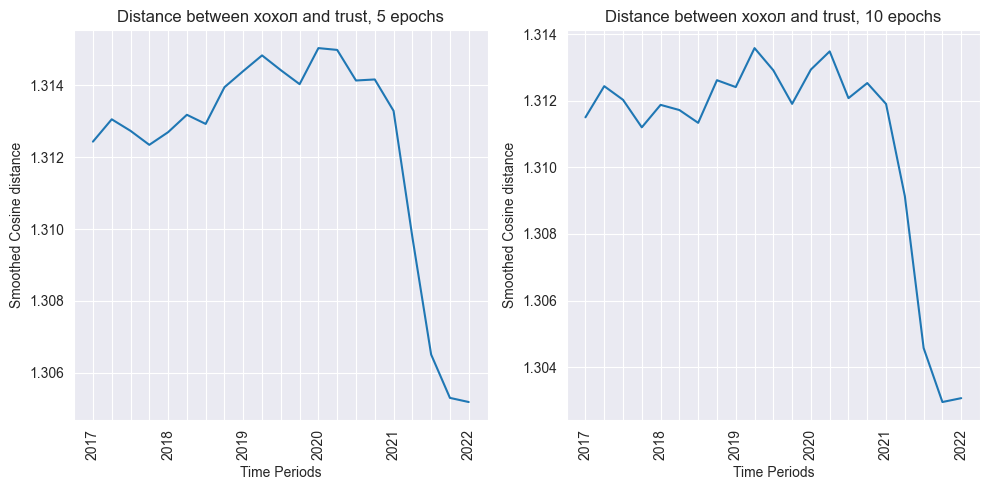

In [630]:
plot_all_concept('—Ö–æ—Ö–æ–ª', lists_dict['trustrus'], 'trust')


['—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–æ–º', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç—É', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–æ–≤', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–∞', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç—ã', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–µ', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–∞–º–∏', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–∞–º', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–∞—Ö']
********************************************************************************
['', '–¥–∏—Å–∫—Ä–∏–º–∏–Ω–∞—Ü–∏—è', '—Ç–æ—à–Ω–æ—Ç—ã', '–≤–æ—Ä—á–∞–ª–∞', '–ø–æ–Ω–µ–ø—Ä–æ—Å—Ç–∏—Ç–µ–ª—å–Ω–µ–µ', '–ø–æ–Ω–µ–ø–æ–∫–æ—Ä–Ω–µ–µ', '–∏–∑–≤—Ä–∞—Ç–∏—Ç', '–Ω–∞–∫–∞–∑–∞–Ω–Ω–∞—è', '–Ω–µ–ø—Ä–∏—Å—Ç–æ–π–Ω–æ–º—É', '–≤—Ä–∞–≥–æ–º', '–¥–µ—Ñ–µ–∫—Ç–Ω–æ–µ', '–Ω–∞–∏–ø–æ–¥–ª–µ–π—à–µ–≥–æ', '–ø–∞–¥–æ–Ω–∫–∞', '—Ä–∞–∑–¥—É–≤—à–µ–º', '–≤–æ–ª–æ—Å–∞—Ç–µ–π—à–µ–º', '—Ñ–ª–∏–≥–µ–ª—å', '—Ç–µ—Ä–º–∏—Ç—É', '—à—É–º–æ–≤', '–±–µ—Å—Å–º—ã—Å–ª–µ–Ω–Ω–µ–π—à–∏—Ö', '–∂–µ–ª–∞—Ç–∏–Ω–µ']
['—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–æ–º', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç—É', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–æ–≤', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–∞', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç—ã', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–µ', '—É–∫—Ä–æ–

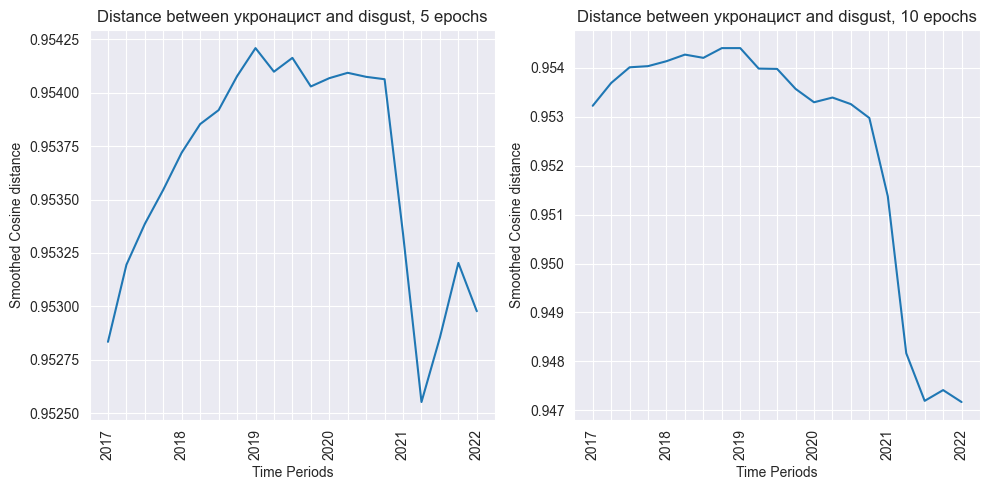

In [668]:
plot_all_concept('—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç', lists_dict['disgustrus'], 'disgust')

['—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–æ–º', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç—É', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–æ–≤', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–∞', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç—ã', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–µ', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–∞–º–∏', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–∞–º', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–∞—Ö']
********************************************************************************
['', '—à–∞–Ω—Ç–∞–∂–∏—Ä–æ–≤–∞–Ω–Ω—ã–µ', '–ø—Ä–∞–≤—è—â—É—é', '–Ω–∞–∏–æ–ø–∞—Å–Ω–µ–π—à–∏–º–∏', '–¥–∏—Å–∫—Ä–∏–º–∏–Ω–∞—Ü–∏—è', '–æ—Ç—Å—É—Ç—Å—Ç–≤—É–π—Ç–µ', '–ø–æ—Ö–æ—Ä–æ–Ω–∏–≤—à–µ–µ', '–∫–æ—Ä–∞–±–ª–µ–∫—Ä—É—à–µ–Ω—å—è—Ö', '—Ä–∞–∑—Ä—É—à–∏—Ç–µ–ª–µ', '–Ω–∞–∫–∞–∑–∞–Ω–Ω–∞—è', '–≥—Ä—É–±–æ—Å—Ç—å', '–∑–∞–≥–∞–¥–æ—á–Ω–æ–µ', '—Ö–ª–æ–ø–∞–µ–º—ã–µ', '–≤—Ä–∞–≥–æ–º', '–Ω–∞–∏–ø–æ–¥–ª–µ–π—à–µ–≥–æ', '–¥–µ–ø–æ—Ä—Ç–∏—Ä—É–µ–º—ã—Ö', '–∑–∞–≥–∞–¥–æ—á–Ω–∞', '–±—Ä–æ–Ω–∏—Ä—É–µ–º—ã–π', '—É–±–µ–∂–∏—â', '–ø—Ä–∏—á–∏–Ω—è—Ç—å']
['—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–æ–º', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç—É', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–æ–≤', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–∞', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç—ã'

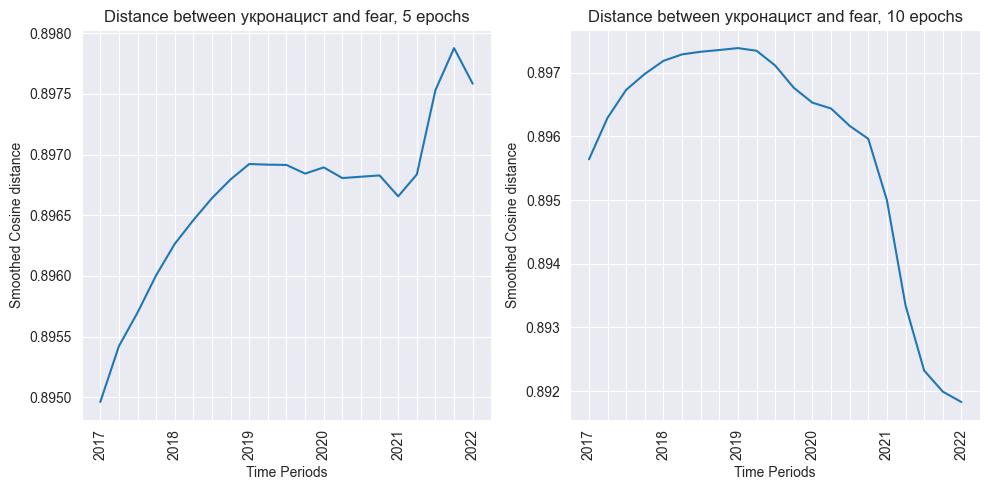

In [660]:
plot_all_concept('—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç', lists_dict['fearrus'], 'fear')

['—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–æ–º', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç—É', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–æ–≤', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–∞', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç—ã', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–µ', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–∞–º–∏', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–∞–º', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–∞—Ö']
********************************************************************************
['', '–Ω–∞–∏–æ–ø–∞—Å–Ω–µ–π—à–∏–º–∏', '–¥–∏—Å–∫—Ä–∏–º–∏–Ω–∞—Ü–∏—è', '—Å–≤–∞–ª–∫–∞—Ö', '–æ—Ç—Å—É—Ç—Å—Ç–≤—É–π—Ç–µ', '–ø–æ—Ö–æ—Ä–æ–Ω–∏–≤—à–µ–µ', '–∫–æ—Ä–∞–±–ª–µ–∫—Ä—É—à–µ–Ω—å—è—Ö', '–ø–æ–Ω–µ–ø—Ä–æ—Å—Ç–∏—Ç–µ–ª—å–Ω–µ–µ', '–Ω–∞–∫–∞–∑–∞–Ω–Ω–∞—è', '–ø–æ–Ω–µ—Å–ø–æ—Å–æ–±–Ω–µ–π', '–≤—ã–ª–µ—Ç –∏–∑—à–∞—è', '–¥–µ–ø–æ—Ä—Ç–∏—Ä—É–µ–º—ã—Ö', '–ø–æ—Ç–µ—Ä—è–Ω–Ω–æ–µ', '–∞–ø–∞—Ç–∏—á–Ω—ã–º', '–ø—Ä–∏—á–∏–Ω—è—Ç—å', '–±–µ—Å—Å–º—ã—Å–ª–µ–Ω–Ω–µ–π—à–∏—Ö', '—Å–ø–æ–π–ª–µ—Ä–∞–º–∏', '—Ö–∏—â–Ω–æ', '–Ω–µ–≤–Ω–∏–º–∞—Ç–µ–ª—å–Ω—ã–µ', '—Å–∫–æ—Ä–±–∏—à—å']
['—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–æ–º', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç—É', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–æ–≤', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–∞

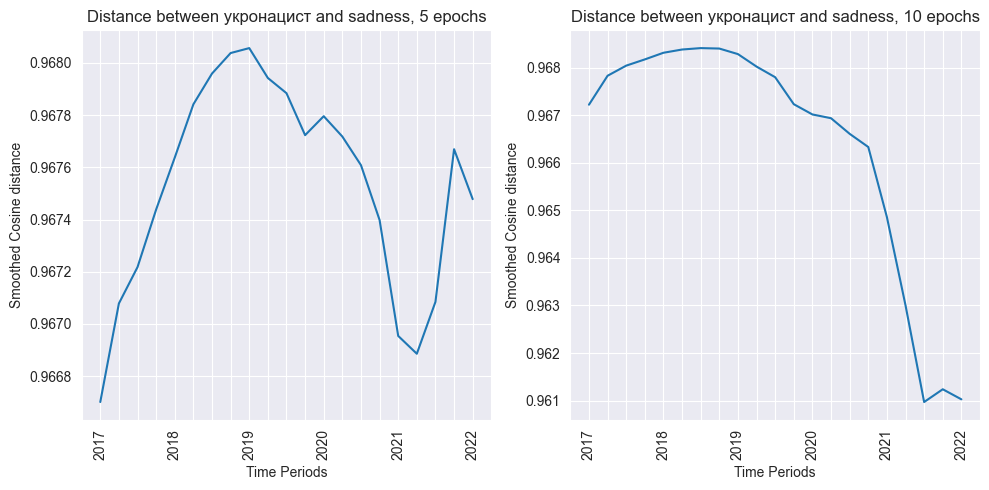

In [663]:
plot_all_concept('—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç', lists_dict['sadnessrus'], 'sadness')

['—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–æ–º', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç—É', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–æ–≤', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–∞', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç—ã', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–µ', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–∞–º–∏', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–∞–º', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–∞—Ö']
********************************************************************************
['', '—à–∞–Ω—Ç–∞–∂–∏—Ä–æ–≤–∞–Ω–Ω—ã–µ', '–¥–∏—Å–∫—Ä–∏–º–∏–Ω–∞—Ü–∏—è', '—Å–≤–∞–ª–∫–∞—Ö', '–≤–æ—Ä—á–∞–ª–∞', '–ø–æ–Ω–µ–ø—Ä–æ—Å—Ç–∏—Ç–µ–ª—å–Ω–µ–µ', '–ø–æ–Ω–µ–ø–æ–∫–æ—Ä–Ω–µ–µ', '—Ä–∞–∑—Ä—É—à–∏—Ç–µ–ª–µ', '–Ω–∞–∫–∞–∑–∞–Ω–Ω–∞—è', '–≥—Ä—É–±–æ—Å—Ç—å', '—Ö–ª–æ–ø–∞–µ–º—ã–µ', '–≤—Ä–∞–≥–æ–º', '–Ω–∞–∏–ø–æ–¥–ª–µ–π—à–µ–≥–æ', '–æ—Ç–º–µ–Ω—è–µ–º', '–ø—Ä–∏—á–∏–Ω—è—Ç—å', '–∑–∞—â–∏—Ç—É', '—à—É–º–æ–≤', '–±–µ—Å—Å–º—ã—Å–ª–µ–Ω–Ω–µ–π—à–∏—Ö', '–≥–∞—à–µ–Ω–Ω—ã–º–∏', '—Ö–∏—â–Ω–æ']
['—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–æ–º', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç—É', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–æ–≤', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–∞', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç—ã', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–µ', '—É–∫—Ä–æ–

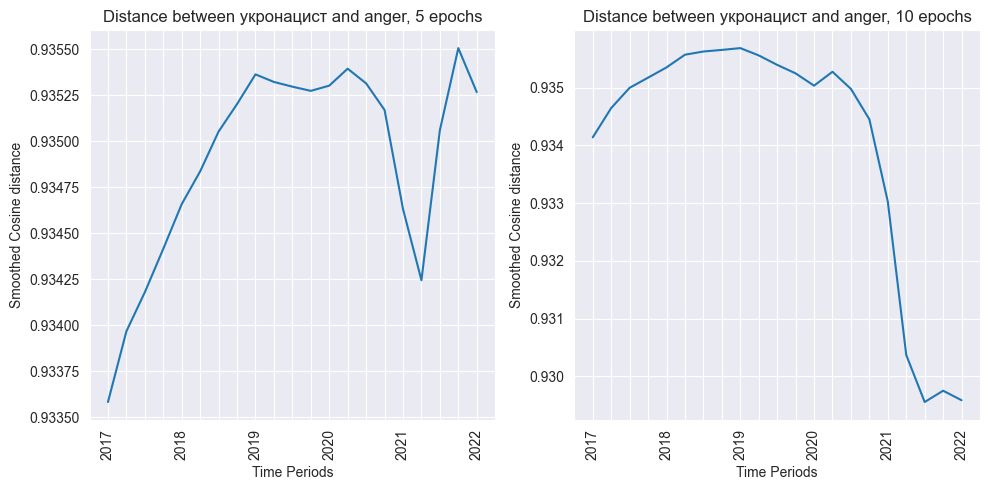

In [662]:
plot_all_concept('—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç', lists_dict['angerrus'], 'anger')

['—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–æ–º', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç—É', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–æ–≤', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–∞', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç—ã', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–µ', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–∞–º–∏', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–∞–º', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–∞—Ö']
********************************************************************************
['', '–ø—Ä–∞–≤—è—â—É—é', '—Ä–∞–∑—ä—è—Å–Ω—ë–Ω–Ω—ã–º–∏', '–ø–æ—á—Ç–µ–Ω–∏—è—Ö', '–ø–æ—Å–º–µ–∏–≤–∞—é—Ç—Å—è', '–ø–æ—Ä—É—á–µ–Ω–∏—è—Ö', '–æ–±–Ω–∏–º–∞—é—â–µ–π', '—Å–æ—Å—Ç–∞–≤–ª—è–µ–º', '–ø—Ä–∏—Ö–æ–¥–æ–º', '—Å–ø–ª–æ—á–µ–Ω–∞', '–≤—ã–∑–¥–æ—Ä–æ–≤–ª–µ–Ω–∏–µ', '–æ–∂–∏–≤–∏–º', '–¥–æ–ø–æ–ª–Ω—è–µ–º–∞', '–ø–æ–ª—É–ª–µ–∂–∞–≤—à–µ–º', '–Ω–∞–ø–æ–ª–Ω—è—é—â–µ–π', '–Ω–∞–∫–ª–æ–Ω—è–µ—à—å', '–∑–∞—â–∏—Ç—É', '—Å—Ç–æ—Ä–æ–∂–∞—â–µ–º—É', '—É–º–Ω–µ–π—à–µ–º', '–º–æ–Ω–æ–≥–∞–º–∏—è—Ö']
['—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–æ–º', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç—É', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–æ–≤', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–∞', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç—ã', '—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç–µ', '—É–∫—Ä–æ–Ω–

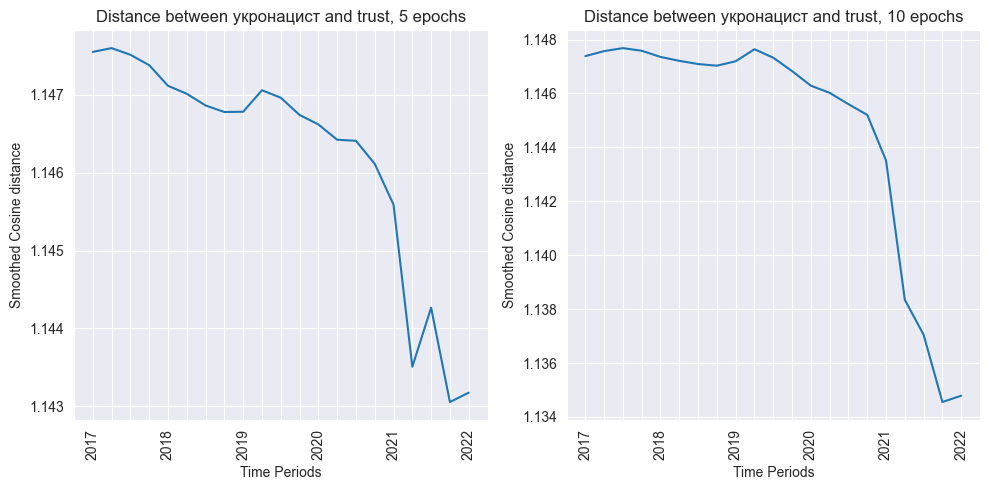

In [661]:
plot_all_concept('—É–∫—Ä–æ–Ω–∞—Ü–∏—Å—Ç', lists_dict['trustrus'], 'trust')

['—É–∫—Ä–æ–ø–∏—Ç–µ–∫—É', '—É–∫—Ä–æ–ø–∏—Ç–µ–∫', '—É–∫—Ä–æ–ø–∏—Ç–µ–∫–∞–º', '—É–∫—Ä–æ–ø–∏—Ç–µ–∫–µ', '—É–∫—Ä–æ–ø–∏—Ç–µ–∫–∞—Ö', '—É–∫—Ä–æ–ø–∏—Ç–µ–∫–∞–º–∏', '—É–∫—Ä–æ–ø–∏—Ç–µ–∫–æ–≤', '—É–∫—Ä–æ–ø–∏—Ç–µ–∫–∏', '—É–∫—Ä–æ–ø–∏—Ç–µ–∫–∞', '—É–∫—Ä–æ–ø–∏—Ç–µ–∫–æ–º']
********************************************************************************
['', '–¥–∏—Å–∫—Ä–∏–º–∏–Ω–∞—Ü–∏—è', '—Ç–æ—à–Ω–æ—Ç—ã', '–≤–æ—Ä—á–∞–ª–∞', '–ø–æ–Ω–µ–ø—Ä–æ—Å—Ç–∏—Ç–µ–ª—å–Ω–µ–µ', '–ø–æ–Ω–µ–ø–æ–∫–æ—Ä–Ω–µ–µ', '–∏–∑–≤—Ä–∞—Ç–∏—Ç', '–Ω–∞–∫–∞–∑–∞–Ω–Ω–∞—è', '–Ω–µ–ø—Ä–∏—Å—Ç–æ–π–Ω–æ–º—É', '–≤—Ä–∞–≥–æ–º', '–¥–µ—Ñ–µ–∫—Ç–Ω–æ–µ', '–Ω–∞–∏–ø–æ–¥–ª–µ–π—à–µ–≥–æ', '–ø–∞–¥–æ–Ω–∫–∞', '—Ä–∞–∑–¥—É–≤—à–µ–º', '–≤–æ–ª–æ—Å–∞—Ç–µ–π—à–µ–º', '—Ñ–ª–∏–≥–µ–ª—å', '—Ç–µ—Ä–º–∏—Ç—É', '—à—É–º–æ–≤', '–±–µ—Å—Å–º—ã—Å–ª–µ–Ω–Ω–µ–π—à–∏—Ö', '–∂–µ–ª–∞—Ç–∏–Ω–µ']
['—É–∫—Ä–æ–ø–∏—Ç–µ–∫—É', '—É–∫—Ä–æ–ø–∏—Ç–µ–∫', '—É–∫—Ä–æ–ø–∏—Ç–µ–∫–∞–º', '—É–∫—Ä–æ–ø–∏—Ç–µ–∫–µ', '—É–∫—Ä–æ–ø–∏—Ç–µ–∫–∞—Ö', '—É–∫—Ä–æ–ø–∏—Ç–µ–∫–∞–º–∏', '—É–∫—Ä–æ–ø–∏—Ç–µ–∫–æ–≤', '—É–∫—Ä–æ–ø–∏—Ç–µ–∫–∏', '—É–∫—Ä–æ–ø–∏—

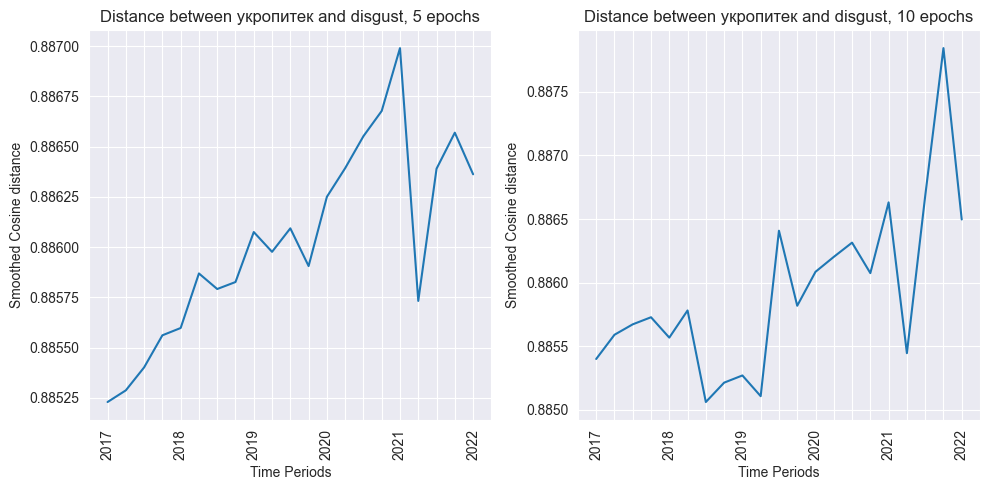

In [669]:
plot_all_concept('—É–∫—Ä–æ–ø–∏—Ç–µ–∫', lists_dict['disgustrus'], 'disgust')

['—É–∫—Ä–æ–ø–∏—Ç–µ–∫—É', '—É–∫—Ä–æ–ø–∏—Ç–µ–∫', '—É–∫—Ä–æ–ø–∏—Ç–µ–∫–∞–º', '—É–∫—Ä–æ–ø–∏—Ç–µ–∫–µ', '—É–∫—Ä–æ–ø–∏—Ç–µ–∫–∞—Ö', '—É–∫—Ä–æ–ø–∏—Ç–µ–∫–∞–º–∏', '—É–∫—Ä–æ–ø–∏—Ç–µ–∫–æ–≤', '—É–∫—Ä–æ–ø–∏—Ç–µ–∫–∏', '—É–∫—Ä–æ–ø–∏—Ç–µ–∫–∞', '—É–∫—Ä–æ–ø–∏—Ç–µ–∫–æ–º']
********************************************************************************
['', '—à–∞–Ω—Ç–∞–∂–∏—Ä–æ–≤–∞–Ω–Ω—ã–µ', '–ø—Ä–∞–≤—è—â—É—é', '–Ω–∞–∏–æ–ø–∞—Å–Ω–µ–π—à–∏–º–∏', '–¥–∏—Å–∫—Ä–∏–º–∏–Ω–∞—Ü–∏—è', '–æ—Ç—Å—É—Ç—Å—Ç–≤—É–π—Ç–µ', '–ø–æ—Ö–æ—Ä–æ–Ω–∏–≤—à–µ–µ', '–∫–æ—Ä–∞–±–ª–µ–∫—Ä—É—à–µ–Ω—å—è—Ö', '—Ä–∞–∑—Ä—É—à–∏—Ç–µ–ª–µ', '–Ω–∞–∫–∞–∑–∞–Ω–Ω–∞—è', '–≥—Ä—É–±–æ—Å—Ç—å', '–∑–∞–≥–∞–¥–æ—á–Ω–æ–µ', '—Ö–ª–æ–ø–∞–µ–º—ã–µ', '–≤—Ä–∞–≥–æ–º', '–Ω–∞–∏–ø–æ–¥–ª–µ–π—à–µ–≥–æ', '–¥–µ–ø–æ—Ä—Ç–∏—Ä—É–µ–º—ã—Ö', '–∑–∞–≥–∞–¥–æ—á–Ω–∞', '–±—Ä–æ–Ω–∏—Ä—É–µ–º—ã–π', '—É–±–µ–∂–∏—â', '–ø—Ä–∏—á–∏–Ω—è—Ç—å']
['—É–∫—Ä–æ–ø–∏—Ç–µ–∫—É', '—É–∫—Ä–æ–ø–∏—Ç–µ–∫', '—É–∫—Ä–æ–ø–∏—Ç–µ–∫–∞–º', '—É–∫—Ä–æ–ø–∏—Ç–µ–∫–µ', '—É–∫—Ä–æ–ø–∏—Ç–µ–∫–∞—Ö', '—É–∫—Ä–æ–ø–∏—Ç–µ–∫–∞–º–∏', '—É–∫—Ä–æ–ø–∏—Ç–µ–∫–æ–≤', 

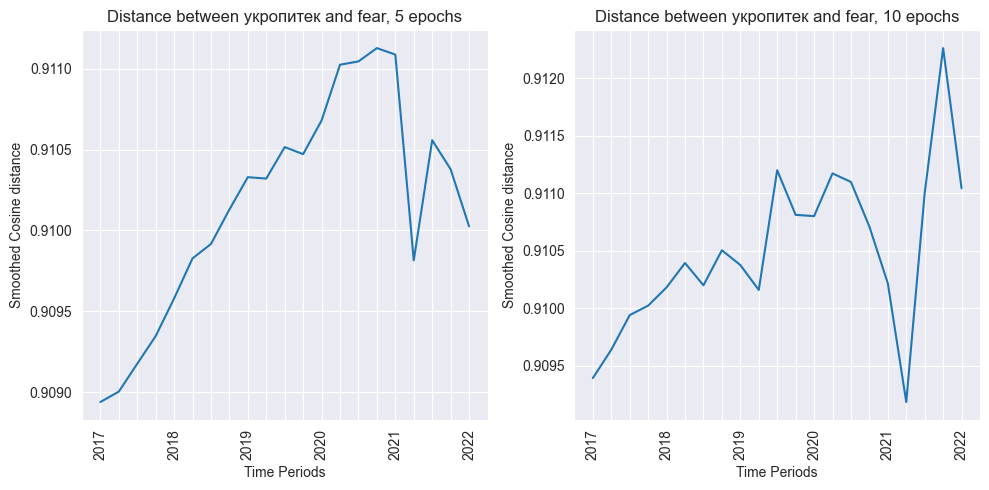

In [670]:
plot_all_concept('—É–∫—Ä–æ–ø–∏—Ç–µ–∫', lists_dict['fearrus'], 'fear')